In [18]:
import pandas as pd
import matplotlib as mpl
from scipy import stats
import scipy.special
import os
from scipy import constants
from colossus.cosmology import cosmology
from astropy.cosmology import z_at_value
from glob import glob
from astropy import units as unit
from astropy.coordinates import SkyCoord
from calculation_method import *
params = {'flat': True, 'H0': 67.77, 'Om0': 0.307, 'Ob0': 0.04825, 'sigma8': 0.8288, 'ns': 0.9611}
cosmology.addCosmology('planck14', params)
cosmo = cosmology.setCosmology('planck14')
import scipy.stats
import pandas as pd

In [19]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, FixedLocator
from matplotlib.backends.backend_pdf import PdfPages

plt.style.use("shao.mplstyle")
fontSize = 15
lineWidth = 1.5

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', \
          u'#bcbd22', u'#17becf']

In [20]:
# central_R200_l = np.loadtxt('central_R200.txt')
# simulation_num_l = [1,2,3,4]
# simulation = 'zcut7'

In [21]:
R_max = 300.  # physical kpc
Mstar_min = 100.  # in solar masses
stack=True

In [22]:
# specify for which entries below to calculate the satellite positions at each redshift
#systems = [16, 17, 18, 19]
systems = [0]

# central galaxy index (i.e.) position in the Galform file (one entry per system)
# only needed for the systems where the central is not a type=0 galaxy with the largest halo mass
# index of the galaxy in the Galform file dataset 'Output001'

simulation_names = [
    "M1_zcut7", # 0
    "M2_zcut7",
    "M3_zcut7",
    "M4_zcut7",
    "M5_zcut7",
    "M1_7DM_GAS", # 5
    "M2_7DM_GAS",
    "M3_7DM_GAS",
    "M4_7DM_GAS",
    "M5_7DM_GAS"
]

centralIndeces = [
    0,    # M1_zcut7
    0,    # M2_zcut7
    0,    # M3_zcut7
    518,  # M4_zcut7
    79,   # M5_zcut7
    0,    # M1_7DM_GAS
    387,  # M2_7DM_GAS
    0,    # M3_7DM_GAS
    581,  # M4_7DM_GAS
    0,    # M5_7DM_GAS
]

# path to the input files
root_galformFiles = "/home/zhaox/Magpie/Galform/"
list_galformFiles = [
    "M1_zcut7/galaxies.hdf5",
    "M2_zcut7/galaxies.hdf5",
    "M3_zcut7/galaxies.hdf5",
    "M4_zcut7/galaxies.hdf5",
    "M5_zcut7/galaxies.hdf5",
    "M1_7DM_GAS/galaxies.hdf5",
    "M2_7DM_GAS/galaxies.hdf5",
    "M3_7DM_GAS/galaxies.hdf5",
    "M4_7DM_GAS/galaxies.hdf5",
    "M5_7DM_GAS/galaxies.hdf5",
]

# path to the input particle data files
root_subhaloFiles = "/home/zhaox/Magpie/"
list_subhaloFiles = [
    "M1_zcut7/groups_%03i_z???p???/",
    "M2_zcut7/groups_%03i_z???p???/",
    "M3_zcut7/groups_%03i_z???p???/",
    "M4_zcut7/groups_%03i_z???p???/",
    "M5_zcut7/groups_%03i_z???p???/",
    "M1_7DM_GAS/groups_%03i_z???p???/",
    "M2_7DM_GAS/groups_%03i_z???p???/",
    "M3_7DM_GAS/groups_%03i_z???p???/",
    "M4_7DM_GAS/groups_%03i_z???p???/",
    "M5_7DM_GAS/groups_%03i_z???p???/",
]

# path to the output 
root_satelliteFiles = "/home/zhaox/Magpie/Destruction/satellite_orbits_Galform/"
list_satelliteFiles = [
    "M1_MR.hdf5",
    "M2_MR.hdf5",
    "M3_MR.hdf5",
    "M4_MR.hdf5",
    "M5_MR.hdf5",
    "M1_7DM_GAS.hdf5",
    "M2_7DM_GAS.hdf5",
    "M3_7DM_GAS.hdf5",
    "M4_7DM_GAS.hdf5",
    "M5_7DM_GAS.hdf5",
]

# path to the output files for figures
plotFigures = True
root_plotFiles = "./fig/"
list_plotFiles = [
    "M1_MR_orbits.pdf",
    "M2_MR_orbits.pdf",
    "M3_MR_orbits.pdf",
    "M4_MR_orbits.pdf",
    "M5_MR_orbits.pdf",
    "M1_7DM_GAS_orbits.pdf",
    "M2_7DM_GAS_orbits.pdf",
    "M3_7DM_GAS_orbits.pdf",
    "M4_7DM_GAS_orbits.pdf",
    "M5_7DM_GAS_orbits.pdf",
]

if systems is None:
    systems = list(range(len(centralIndeces)))

# within r200
# dm_halo_minor_l = np.array([[-0.22037225,  0.9744935 ,   0.04240861],
#                             [0.18181571,   0.42799015,  -0.88530643],
#                             [0.30559745,   0.3931947 ,   0.86718402],
#                             [0.27163464,  -0.00129548,  -0.96239958],
#                             [0.17690542,   0.04002508,  -0.98341368]])

# [-0.18031118 -0.48783585  0.8541101 ]

# within 300kpc
dm_halo_minor_l =np.array([np.array([-0.22264078,  0.9694128 ,  0.10329524]),
                            np.array([-0.18031118, -0.48783585,  0.8541101 ]),
                            np.array([0.3382086 , 0.42797622, 0.83812368]),
                            np.array([ 0.18470191, -0.10744712, -0.97690343]),
                            np.array([-0.43115722, -0.16135785,  0.88773143])])

central_GroupNumber_l = [1,1,1,2,2,1,2,1,3,1]

# 1 read data

In [23]:
def read_satellite_orbit_Galform(satelliteFile):
# within 300kpc, > mass_min, after tidal destruction

    with h5py.File(satelliteFile, 'r' ) as hf:
        # data = hf[inputFile]
        # print ("data.keys = " , data.keys())
        # gid = data['GalaxyID'][:]
        # num = len(gid)
        # print("hf.keys()", hf.keys())
        # print("hf/satellite_galaxies.keys()",hf['satellite_galaxies'].keys())
        t = hf["header_info/time"][:]
        a = hf["header_info/scale_factor"][:]
        h = hf['header_info/h'][()].astype(np.float64)
        z = hf["header_info/redshift"][:]
        # central_Mhalo = hf['central_galaxy/Mhalo'][:]
        central_Mstar = hf['central_galaxy/Mstar'][:]
        satellite_ID = hf['satellite_galaxies/ID'][:]
        satellite_mstar = hf['satellite_galaxies/Mstar'][:]
        # satellite_msub = hf['satellite_galaxies/Msub'][:]
        # satellite_mhalo = hf['satellite_galaxies/Mhalo'][:]
        satellite_pos = hf['satellite_galaxies/pos'][:]
        # central_pos = hf['satellite_galaxies/pos'][:]
        satellite_vel = hf['satellite_galaxies/vel'][:]
        satellite_type = hf['satellite_galaxies/type'][:]
        # satellite_R200 = hf['satellite_galaxies/R200'][:]
        # is_MW_central = hf['satellite_galaxies/is_MW_central'][:]
        # Last snapshot at which the galaxy is a FOF central subhalo. Different from Galform definition of central galaxy.
        # satellite_snap_last_FOF_central = hf['satellite_galaxies/snap_last_FOF_central'][:]
        # Last snapshot at which the galaxy was a central.
        # satellite_snap_last_central = hf["satellite_galaxies/snap_last_central"][:]
        # satellite_type = hf["satellite_galaxies/type"][:]
        destruction = hf["tidal_disruption/destroyed_orbit_interpolation"][:]
    
    # print("d<300,m>0 satellite num=", len(satellite_mstar))
    
    distance_z0 = np.linalg.norm(satellite_pos[:,0,:], axis=1)
    print("d<%d,m>%d satellite num="%(R_max, Mstar_min), sum((satellite_mstar[:,0]>=Mstar_min) & (distance_z0<=R_max)))
    # R200 = 227.2 * (central_Mhalo/1.252e12)**0.3333

    for i in range(len(satellite_type)):
        if satellite_type[i,0] != 2:
            destruction[i] = False
    is_satellite = (satellite_mstar[:,0]>=Mstar_min) & (destruction==False) & (distance_z0<=R_max)
    satellite_mstar = satellite_mstar[is_satellite]
    satellite_pos = satellite_pos[is_satellite]
    # satellite_ID = satellite_ID[is_satellite]
    # satellite_mhalo = satellite_mhalo[is_satellite]
    satellite_vel = satellite_vel[is_satellite]
    # satellite_R200 = satellite_R200[is_satellite]
    print("d<%d,m>%d after destruction satellite num="%(R_max, Mstar_min), sum(is_satellite))
    print("central Mstar=%.3e, LMC Mstar=%.3e"%(central_Mstar[0],np.max(satellite_mstar[:,0])))
    return satellite_ID, satellite_mstar, satellite_pos, satellite_vel, destruction, is_satellite, t, a, h, z


def readActualData(hf, numObjs, numSnaps, gal_ID_start, gal_ID_end):
    """Reads the data for the most massive progenitor of z=0 galaxies at each redshift they exist."""
    # quantities that store redshift info
    # reserve memory for the main progenitor of each z=0 galaxy
    gal_ID = -np.ones((numObjs, numSnaps), np.int64)
    gal_type = -np.ones((numObjs, numSnaps), np.int32)
    gal_pos = np.zeros((numObjs, numSnaps, 3), np.float64)
    gal_vel = np.zeros((numObjs, numSnaps, 3), np.float64)
    gal_Mstar = np.zeros((numObjs, numSnaps), np.float64)  # stellar mass
    # half stellar mass radius
    gal_RHalf = np.zeros((numObjs, numSnaps), np.float64)
    gal_Mhalo = np.zeros((numObjs, numSnaps), np.float64)  # host halo mass
    # subhalo index in Subfind catalogue
    gal_subIndex = -np.ones((numObjs, numSnaps), np.int32)
    # snapnum*10^12+filenum*10^8+gal_subIndex
    gal_subID = -np.ones((numObjs, numSnaps), np.int64)

    # loop over each snapshot and read the position and other properties of the main galaxy progenitor
    print("\tReading the info at each Galform output ...")
    for i in range(1, numSnaps+1):
        dataset = 'Output%03i/' % i
        if dataset[:-1] in hf.keys() and 'GalaxyID' in hf[dataset].keys():
            temp_index = np.empty(numObjs, np.int32)
            temp_ID = np.array(hf[dataset + 'GalaxyID'])
            for j in range(numObjs):
                current_index = np.where(
                    (temp_ID >= gal_ID_start[j]) * (temp_ID <= gal_ID_end[j]))[0]
                temp_index[j] = current_index[0] if len(
                    current_index) > 0 else -1

            # get the number of objects with a progenitor at this redshift
            valid = temp_index >= 0
            if valid.sum() == 0:  # no progenitor present
                continue
            if i % 10 == 0:
                print("\t\toutput %i has %i progenitors" % (i, valid.sum()))
            temp_index = temp_index[valid]
            gal_ID[:, i-1][valid] = temp_ID[temp_index]
            gal_type[:, i -
                     1][valid] = np.array(hf[dataset + 'type'])[temp_index]
            gal_pos[:, i-1][valid] = np.column_stack((np.array(hf[dataset+'xgal']),
                                                      np.array(
                                                          hf[dataset+'ygal']),
                                                      np.array(hf[dataset+'zgal'])))[temp_index]
            gal_vel[:, i-1][valid] = np.column_stack((np.array(hf[dataset+'vxgal']),
                                                      np.array(
                                                          hf[dataset+'vygal']),
                                                      np.array(hf[dataset+'vzgal'])))[temp_index]
            # sum the bulge and disk stellar masses
            gal_Mstar[:, i-1][valid] = np.array(hf[dataset + 'mstars_bulge'])[temp_index] + \
                np.array(hf[dataset + 'mstars_disk'])[temp_index]
            # calculate the half stellar mass radius as a weighted mean of the bulge and disk values
            gal_RHalf[:, i-1][valid] = (np.array(hf[dataset + 'mstars_bulge'])[temp_index] *
                                        np.array(hf[dataset + 'rbulge'])[temp_index] +
                                        np.array(hf[dataset + 'mstars_disk'])[temp_index] *
                                        np.array(hf[dataset + 'rdisk'])[temp_index]) / \
                gal_Mstar[:, i-1][valid]
            gal_Mhalo[:, i -
                      1][valid] = np.array(hf[dataset + 'mchalo'])[temp_index]
            gal_subIndex[:, i -
                         1][valid] = np.array(hf[dataset + 'SubhaloIndex'])[temp_index]
            gal_subID[:, i -
                      1][valid] = np.array(hf[dataset + 'SubhaloID'])[temp_index]

    return gal_ID, gal_type, gal_pos, gal_vel, gal_Mstar, gal_RHalf, gal_Mhalo, gal_subIndex, gal_subID


def readGalformGalaxyData(galaxyFile, centralIndex, R_max, Mstar_min):
    """Reads the galaxy data within a Galform file. 

    Finds the most massive galaxy defined as the one with position 'centralIndex' 
    in the file and finds all its satellites, i.e. all galaxies within `R_max`
    with stellar mass larger than `Mstar_min`. 

    Returns multiple properties of the satellites and of their most massive progenitor.

    Also calculates the position and velocities of the central galaxy at each snapshot
    for all satellite progenitors.
    """
    with h5py.File(galaxyFile, 'r') as hf:
        # read the cosmology and snapshot info
        h = np.array(hf['Parameters/h0'])
        Omega0 = np.array(hf['Parameters/omega0'])
        OmegaB = np.array(hf['Parameters/omegab'])
        print("\tcosmological parameters (h, Omega_M, Omega_B): ", h, Omega0, OmegaB)

        redshift = np.array(hf['Output_Times/zout'])
        time = np.array(hf['Output_Times/tout'])
        scale_factor = np.array(hf['Output_Times/aout'])
        snap_number = np.array(hf['Output_Times/snapnum_out'])

        # find the central galaxy
        if centralIndex is None:
            centralIndex, Mhalo_max = findCentralGalaxy(hf)
            print("\tcentral galaxy index and Mhalo/1.e12: ",
                  centralIndex, Mhalo_max/1.e12/h)

        # find the satellites
        satelliteIndex = findSatellites(
            hf, centralIndex, R_max/1.e3*h, Mstar_min*h)
        print("\tthere are %i satellites within %.0f kpc from the central and with Mstar above %.2e Msolar"
              % (satelliteIndex.shape[0], R_max, Mstar_min))

        # Arrays for keeping track of info needed for identifying the most massive progenitor
        numObjs = 1 + satelliteIndex.shape[0]
        indices = np.hstack((centralIndex, satelliteIndex))
        # first ID of each galaxy
        gal_ID_start = np.array(hf['Output001/GalaxyID'])[indices]
        # last main progenitor
        gal_ID_end = np.array(hf['Output001/EndMainBranchID'])[indices]

        # read the snapshot info
        numSnaps = snap_number.shape[0]
        print("\tnumber of snapshots in the file: ", numSnaps)
        gal_ID, gal_type, gal_pos, gal_vel, gal_Mstar, gal_RHalf, gal_Mhalo, gal_subIndex, gal_subID = \
            readActualData(hf, numObjs, numSnaps, gal_ID_start, gal_ID_end)

        # find the pos and velocity of the central galaxy for satellites
        # index at which the galaxy was last a central
        # last a value when galaxy was central
        gal_acHalo = np.array(hf['Output001/achalo'])[indices]
        gal_indexCen = np.interp(
            gal_acHalo, scale_factor[::-1], range(numSnaps)[::-1]).astype(np.int32)
        # alternatively can do this
        # gal_indexCen = np.argmin( np.abs(gal_acHalo[:, None] - scale_factor[None, :]), axis = 1)

        gal_central_pos = np.zeros((numObjs, numSnaps, 3), np.float64)
        gal_central_vel = np.zeros((numObjs, numSnaps, 3), np.float64)
        gal_central_MW = np.zeros((numObjs, numSnaps), bool)
        for j in range(1, numObjs):
            k = gal_indexCen[j] - 1
            if k < 0:  # this is a central at z=0
                continue
            gal_central_pos[j, :k+1], gal_central_vel[j, :k+1], gal_central_MW[j, :k+1] = \
                findMergerTree_central(
                    hf, gal_pos[j, k], k, gal_ID[0], gal_pos[0], gal_vel[0])

    return h, Omega0, OmegaB, redshift, time, scale_factor, snap_number, \
        gal_ID, gal_type, gal_pos, gal_vel, gal_Mstar, gal_RHalf, gal_Mhalo, gal_subIndex, gal_subID, \
        gal_indexCen, gal_central_pos, gal_central_vel, gal_central_MW


def readGalformGalsubID(galaxyFile, centralIndex, R_max, Mstar_min):
    """Reads the galaxy data within a Galform file. 

    Finds the most massive galaxy defined as the one with position 'centralIndex' 
    in the file and finds all its satellites, i.e. all galaxies within `R_max`
    with stellar mass larger than `Mstar_min`. 

    Returns multiple properties of the satellites and of their most massive progenitor.

    Also calculates the position and velocities of the central galaxy at each snapshot
    for all satellite progenitors.
    """
    with h5py.File(galaxyFile, 'r') as hf:
        # read the cosmology and snapshot info
        h = np.array(hf['Parameters/h0'])
        snap_number = np.array(hf['Output_Times/snapnum_out'])

        # find the central galaxy
        if centralIndex is None:
            centralIndex, Mhalo_max = findCentralGalaxy(hf)
            print("\tcentral galaxy index and Mhalo/1.e12: ",
                  centralIndex, Mhalo_max/1.e12/h)

        # find the satellites
        satelliteIndex = findSatellites(
            hf, centralIndex, R_max/1.e3*h, Mstar_min*h)
        print("\tthere are %i satellites within %.0f kpc from the central and with Mstar above %.2e Msolar"
              % (satelliteIndex.shape[0], R_max, Mstar_min))

        # Arrays for keeping track of info needed for identifying the most massive progenitor
        numObjs = 1 + satelliteIndex.shape[0]
        indices = np.hstack((centralIndex, satelliteIndex))
        # first ID of each galaxy
        gal_ID_start = np.array(hf['Output001/GalaxyID'])[indices]
        # last main progenitor
        gal_ID_end = np.array(hf['Output001/EndMainBranchID'])[indices]

        # read the snapshot info
        numSnaps = snap_number.shape[0]
        print("\tnumber of snapshots in the file: ", numSnaps)
        gal_subID = -np.ones((numObjs, numSnaps), np.int64)

        # loop over each snapshot and read the position and other properties of the main galaxy progenitor
        print("\tReading the info at each Galform output ...")
        for i in range(1, numSnaps+1):
            dataset = 'Output%03i/' % i
            if dataset[:-1] in hf.keys() and 'GalaxyID' in hf[dataset].keys():
                temp_index = np.empty(numObjs, np.int32)
                temp_ID = np.array(hf[dataset + 'GalaxyID'])
                for j in range(numObjs):
                    current_index = np.where(
                        (temp_ID >= gal_ID_start[j]) * (temp_ID <= gal_ID_end[j]))[0]
                    temp_index[j] = current_index[0] if len(
                        current_index) > 0 else -1

                # get the number of objects with a progenitor at this redshift
                valid = temp_index >= 0
                if valid.sum() == 0:  # no progenitor present
                    continue
                if i % 10 == 0:
                    print("\t\toutput %i has %i progenitors" % (i, valid.sum()))
                temp_index = temp_index[valid]
                gal_subID[:, i -
                        1][valid] = np.array(hf[dataset + 'SubhaloID'])[temp_index]

    return gal_subID



def findSatellites(hf, centralIndex, maxDistance, minMstar):
    """Finds the satellites as all the galaxies within a given distance from the central galaxy."""
    pos = np.column_stack((np.array(hf['Output001/xgal']), np.array(hf['Output001/ygal']),
                           np.array(hf['Output001/zgal'])))
    Mstar = np.array(hf['Output001/mstars_bulge']) + \
        np.array(hf['Output001/mstars_disk'])
    pos0 = pos[centralIndex]
    pos = pos - pos0  # position relative to the central
    dis = (pos**2).sum(axis=1)  # distance from the central
    satellites = dis <= maxDistance**2
    satellites[centralIndex] = False  # remove the central galaxy
    satellites *= Mstar >= minMstar   # stellar mass selection
    return np.where(satellites)[0]


def findMergerTree_central(hf, sat_pos, out_index, MW_ID, MW_pos, MW_vel):
    "Finds the position and velocity of the central galaxy for satellites at each snapshot."
    target_ID = findHost(hf, sat_pos, out_index)  # find the central at infall
    matched = np.where(target_ID == MW_ID)[0]
    if len(matched) >= 1:  # the satellite fell into the MW analogue
        return MW_pos[:out_index+1], MW_vel[:out_index+1], True

    # find the position and velocities of the central galaxy
    pos = np.zeros((out_index+1, 3), np.float64)
    vel = np.zeros((out_index+1, 3), np.float64)
    MWa = np.zeros((out_index+1), bool)
    for i in range(out_index, 0, -1):
        dataset = 'Output%03i/' % (i+1)
        temp_IDs = np.array(hf[dataset+'GalaxyID'])
        sel = temp_IDs == target_ID  # select the target galaxy
#         print(i, target_ID, sel.sum())

        # check if it is central or not
        if np.array(hf[dataset+'is_central'])[sel][0]:  # target galaxy is a central
            target_ID = np.array(hf[dataset+'DescendantID'])[sel][0]
            pos[i, 0] = np.array(hf[dataset+'xgal'])[sel]
            pos[i, 1] = np.array(hf[dataset+'ygal'])[sel]
            pos[i, 2] = np.array(hf[dataset+'zgal'])[sel]
            vel[i, 0] = np.array(hf[dataset+'vxgal'])[sel]
            vel[i, 1] = np.array(hf[dataset+'vygal'])[sel]
            vel[i, 2] = np.array(hf[dataset+'vzgal'])[sel]
        else:  # target galaxy is a satellite, so return position of its own central
            sat_pos = np.column_stack((np.array(hf[dataset+'xgal']), np.array(hf[dataset+'ygal']),
                                       np.array(hf[dataset+'zgal'])))[sel][0]
            pos[:i+1], vel[:i+1], MWa[:i +
                                      1] = findMergerTree_central(hf, sat_pos, i, MW_ID, MW_pos, MW_vel)
            break
    return pos, vel, MWa



def read_file_GrpNum_thread(process_start,process_end, gal_subID, subhaloFile, subfile_basename, numSnaps):
    print(process_start)
    gal_GroupNumber_l = []
    gal_SubGroupNumber_l = []
    for i in range(process_start,process_end):
        gal_GroupNumber = np.zeros(numSnaps, int)
        gal_SubGroupNumber = np.zeros(numSnaps, int)
        for j in range(0, numSnaps):
            if gal_subID[i, j] < 0:
                continue
            ID_temp = gal_subID[i, j]
            a = divmod(ID_temp, 10**15)  # a[0] > 0 if no subhalo exists
            b = divmod(a[1], 10**12)    # b[0] is snapnum
            # c[0] is the file number and c[1] is the index of the subhalo
            c = divmod(b[1], 10**8)
            snapname = subhaloFile % b[0]
            subfilename = snapname + subfile_basename
            inputFiles = glob(subfilename % c[0])
            with h5py.File(inputFiles[0], 'r') as hf:
                        # gal_Msub[i, j] = np.array(
                        #     hf['Subhalo/Mass'])[c[1]] * 1.e10 / HubbleParam
                gal_GroupNumber[j] = np.array(hf['Subhalo/GroupNumber'])[c[1]]
                gal_SubGroupNumber[j] = np.array(hf['Subhalo/SubGroupNumber'])[c[1]]
        gal_GroupNumber_l.append(gal_GroupNumber)
        gal_SubGroupNumber_l.append(gal_SubGroupNumber)
    print("\t\t %ith galaxy finished" % (process_end))
    return gal_GroupNumber_l, gal_SubGroupNumber_l

# function for reading in the Subfind data
def readGrpNum(subhaloFile, gal_subID):
    """Reads the group data from a Subfind file."""
    subfile_basename = 'eagle_subfind_tab_???_z???p???.%i.hdf5'
    # create array for subhalo mass
    numObjs = gal_subID.shape[0]
    numSnaps = gal_subID.shape[1]
    # gal_Msub = np.zeros((numObjs, numSnaps), np.float64)
    gal_GroupNumber = np.zeros((numObjs, numSnaps), int)
    gal_SubGroupNumber = np.zeros((numObjs, numSnaps), int)
    if numObjs <40:
        num_processes = 1
    else:
        num_processes = 40
    import multiprocessing
    pool = multiprocessing.Pool(processes=num_processes)
    results = []
    start = 0
    end = numObjs
    chunk_size = (end - start) // num_processes + 1 
    for i in range(num_processes+1):
        process_start = start + i * chunk_size
        process_end = process_start + chunk_size
        if process_end > end:
            process_end = end
            # find and read the file
        result = pool.apply_async(read_file_GrpNum_thread, (process_start,process_end, gal_subID, subhaloFile, subfile_basename, numSnaps))
        results.append(result)
    pool.close()
    pool.join()
    
    gal_GroupNumber = []
    gal_SubGroupNumber = []
    for result in results:
        array1, array2 = result.get()
        gal_GroupNumber.extend(array1)
        gal_SubGroupNumber.extend(array2)
    return gal_GroupNumber, gal_SubGroupNumber


def findHost(hf, sat_pos, out_index):
    """Finds the first central galaxy at the infall snapshot of a satellite."""
    dataset = 'Output%03i/' % (out_index+1)

    # select central galaxies
    temp_central = np.array(hf[dataset+'is_central'])
    sel = temp_central == 1

    # get the ids and positions of all centrals
    temp_IDs = np.array(hf[dataset+'GalaxyID'])[sel]
    temp_pos = np.column_stack((np.array(hf[dataset+'xgal']), np.array(hf[dataset+'ygal']),
                                np.array(hf[dataset+'zgal'])))[sel]
    temp_dis = ((temp_pos - sat_pos[None, :])**2).sum(axis=1)
    temp_Rhalo = np.array(hf[dataset+'halo_r_virial'])[sel]

    target = np.argmin(temp_dis / temp_Rhalo)
    return temp_IDs[target]

def read_satellite_hydro_z0(simulation_num, simulation_name, maxn):
    # read the subgroup catalogue
    # inputFile_root = "groups_199_z000p000/eagle_subfind_tab_028_z000p000.%i.hdf5" 
    file = simulation_name
    inputFile_root = '/home/zhaox/Magpie/' + file + '/groups_199_z000p000/eagle_subfind_tab_199_z000p000.%i.hdf5'
    # read the data - read the first tab file to get the total number of subgroups
    inputFile = inputFile_root % 0

    # 对于4和5，中央星系的galaxyID不等于0

    if simulation_name[3:] == 'zcut7':
        if simulation_num == 4:
            centerIndex = 2
        elif simulation_num == 5:
            centerIndex = 2
        else:
            centerIndex = 1
    elif simulation_name[3:] == '7DM_GAS':
        if simulation_num == 2:
            centerIndex = 2
        elif simulation_num == 4:
            centerIndex = 3
        else:
            centerIndex = 1
    else:
        print("can't understand simulation_name!")
        return
    with h5py.File( inputFile, 'r' ) as hf:
        header  = hf['Header'].attrs
        # print ('header keys:', header.keys())
        numFiles = header['NTask']  # this gives the number of files in which the group catalog is saved
        noTotGrps = header['TotNgroups']  # total number of FOF groups
        noTotSubs = header['TotNsubgroups']  # total number of SUBFIND subhaloes
        hFactor   = header['HubbleParam']
        # print("All groups in the file:", hf.keys())
        # print("All entries in the 'FOF' group:", hf['FOF'].keys())
        # print("All entries in the 'SubHalo' group:", hf['Subhalo'].keys())
        # print(numFiles, noTotGrps, noTotSubs, hFactor)


    # reserve memory for the output arrays
    FOF_length   = np.zeros( noTotGrps, np.uint32 )
    FOF_mass     = np.zeros( noTotGrps, np.float32 )
    FOF_pos      = np.zeros( (noTotGrps,3), np.float32 )  # centre of potential
    FOF_M200     = np.zeros( noTotGrps, np.float32 )
    FOF_R200     = np.zeros( noTotGrps, np.float32 )
    Subhalo_mass = np.zeros( noTotSubs, np.float32 )
    Subhalo_pos  = np.zeros( (noTotSubs,3), np.float32 )  # centre of potential
    Subhalo_vel = np.zeros( (noTotSubs,3), np.float32 )
    Subhalo_gnum = np.zeros( noTotSubs, np.float32 )

    # loop over all the various files
    start, end = 0, 0
    start2, end2 = 0, 0
    for i in range(numFiles):
        inFile = inputFile_root % i
        with h5py.File( inFile, 'r' ) as hf:
            h = hf['Header'].attrs
            numGrps = h['Ngroups']  # number of groups this file
            numsubGrps = h['Nsubgroups']
            end = start + numGrps
            end2 = start2 + numsubGrps
    #         print(numsubGrps)
            # print ("Reading file %i of %i --%s-- which contains %i groups ..." % ( i+1, numFiles, inFile, numGrps ))
            
            # FOF_length[start:end] = hf["FOF/GroupLength"]
            # FOF_mass[start:end] = hf["FOF/GroupMass"]
            FOF_pos[start:end]  = hf["FOF/GroupCentreOfPotential"]
            # FOF_M200[start:end] = hf["FOF/Group_M_Crit200"]
            FOF_R200[start:end] = hf["FOF/Group_R_Crit200"]
            Subhalo_pos[start2:end2] = hf["Subhalo/CentreOfPotential"]
            Subhalo_mass[start2:end2] = hf["Subhalo/MassType"][:,4]
            Subhalo_vel[start2:end2] = hf["Subhalo/Velocity"]
            Subhalo_gnum[start2:end2] = hf["Subhalo/GroupNumber"]
            start = end
            start2 = end2
    Subhalo_pos = (Subhalo_pos - FOF_pos[centerIndex-1])* 1000/hFactor
    satellite_index = []
    dis = []
    for i in range(len(Subhalo_pos)):
        dis_ = ((Subhalo_pos[i][0]**2 + Subhalo_pos[i][1]**2 + Subhalo_pos[i][2]**2)**0.5)
        # 筛选条件小于300kpc，大于100msun
        # print(dis_)
        if  dis_  < 300 and Subhalo_mass[i] > 0:
            satellite_index.append(i)
            dis.append(dis_)
    # print(satellite_index)
    # 选择groupNumber==centerindex的星系
    # satellite_index = np.where(Subhalo_gnum == centerIndex)

    # print(satellite_index)
    print('r200 = ',FOF_R200[centerIndex-1])
    #计算相对坐标和相对速度
    # satellite_pos = (Subhalo_pos[satellite_index] - FOF_pos[centerIndex-1])* 1000/hFactor
    satellite_pos = Subhalo_pos[satellite_index]
    satellite_vel = Subhalo_vel[satellite_index] - Subhalo_vel[satellite_index][0]
    dis = np.linalg.norm(satellite_pos, axis = 1)
    satellite_data =pd.DataFrame({"groupNumber":Subhalo_gnum[satellite_index], "id":satellite_index,\
            "mass":Subhalo_mass[satellite_index]*1e10/hFactor, "distance[kpc]":dis, \
            "x[kpc]":satellite_pos[:,0],"y[kpc]":satellite_pos[:,1],"z[kpc]":satellite_pos[:,2],\
            "vx[km/s]":satellite_vel[:,0],"vy[km/s]":satellite_vel[:,1],"vz[km/s]":satellite_vel[:,2]},  \
        columns=['groupNumber', 'id', 'mass', 'distance[kpc]', 'x[kpc]', 'y[kpc]', 'z[kpc]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'])
        # 返回显示质量最大的maxn个,maxn=1000表示输出所有满足条件的星系，从1开始是因为0是中央星系
    # satellite_data = all_data[all_data['groupNumber'] == centerIndex+1] 
    # satellite_data = satellite_data.query("mass > 0 & `distance[kpc]` < 300")
    # satellite_index = np.where(satellite_data['groupNumber'] == centerIndex)
    # satellite_data = satellite_data.iloc[satellite_index]
    satellite_data = satellite_data.sort_values(by=['mass'],ascending=False)
    # satellite_data = satellite_data.loc[satellite_data['distance[kpc]']<300 ]
    satellite_pos = np.array(satellite_data[['x[kpc]','y[kpc]','z[kpc]']])
    satellite_vel = np.array(satellite_data[['vx[km/s]','vy[km/s]','vz[km/s]']])
    
    print('center pos:', FOF_pos[centerIndex-1], "satellite num = ", len(satellite_pos)-1)
    return FOF_R200[centerIndex-1], satellite_data.iloc[:maxn+1], satellite_pos[1:maxn+1], satellite_vel[1:maxn+1]
    # return satellite_data.sort_values(by=['mass'],ascending=False).iloc[:]


def read_hydro(simulation_num, simulation_name, maxn):
    # read the subgroup catalogue
    # inputFile_root = "groups_199_z000p000/eagle_subfind_tab_028_z000p000.%i.hdf5" 
    file = simulation_name
    inputFile_root = '/home/zhaox/Magpie/' + file + '/groups_199_z000p000/eagle_subfind_tab_199_z000p000.%i.hdf5'
    # read the data - read the first tab file to get the total number of subgroups
    inputFile = inputFile_root % 0

    # 对于4和5，中央星系的galaxyID不等于0

    if simulation_name[3:] == 'zcut7':
        if simulation_num == 4:
            centerIndex = 2
        elif simulation_num == 5:
            centerIndex = 2
        else:
            centerIndex = 1
    elif simulation_name[3:] == '7DM_GAS':
        if simulation_num == 2:
            centerIndex = 2
        elif simulation_num == 4:
            centerIndex = 3
        else:
            centerIndex = 1
    else:
        print("can't understand simulation_name!")
        return
    with h5py.File( inputFile, 'r' ) as hf:
        header  = hf['Header'].attrs
        # print ('header keys:', header.keys())
        numFiles = header['NTask']  # this gives the number of files in which the group catalog is saved
        noTotGrps = header['TotNgroups']  # total number of FOF groups
        noTotSubs = header['TotNsubgroups']  # total number of SUBFIND subhaloes
        hFactor   = header['HubbleParam']
        # print("All groups in the file:", hf.keys())
        # print("All entries in the 'FOF' group:", hf['FOF'].keys())
        # print("All entries in the 'SubHalo' group:", hf['Subhalo'].keys())
        # print(numFiles, noTotGrps, noTotSubs, hFactor)


    # reserve memory for the output arrays
    FOF_length   = np.zeros( noTotGrps, np.uint32 )
    FOF_mass     = np.zeros( noTotGrps, np.float32 )
    FOF_pos      = np.zeros( (noTotGrps,3), np.float32 )  # centre of potential
    FOF_M200     = np.zeros( noTotGrps, np.float32 )
    FOF_R200     = np.zeros( noTotGrps, np.float32 )
    Subhalo_mass = np.zeros( noTotSubs, np.float32 )
    Subhalo_pos  = np.zeros( (noTotSubs,3), np.float32 )  # centre of potential
    Subhalo_vel = np.zeros( (noTotSubs,3), np.float32 )
    Subhalo_gnum = np.zeros( noTotSubs, np.float32 )

    # loop over all the various files
    start, end = 0, 
    start2, end2 = 0, 0
    for i in range(numFiles):
        inFile = inputFile_root % i
        with h5py.File( inFile, 'r' ) as hf:
            h = hf['Header'].attrs
            numGrps = h['Ngroups']  # number of groups this file
            numsubGrps = h['Nsubgroups']
            end = start + numGrps
            end2 = start2 + numsubGrps
    #         print(numsubGrps)
            # print ("Reading file %i of %i --%s-- which contains %i groups ..." % ( i+1, numFiles, inFile, numGrps ))
            
            # FOF_length[start:end] = hf["FOF/GroupLength"]
            # FOF_mass[start:end] = hf["FOF/GroupMass"]
            FOF_pos[start:end]  = hf["FOF/GroupCentreOfPotential"]
            # FOF_M200[start:end] = hf["FOF/Group_M_Crit200"]
            FOF_R200[start:end] = hf["FOF/Group_R_Crit200"]
            Subhalo_pos[start2:end2] = hf["Subhalo/CentreOfPotential"]
            Subhalo_mass[start2:end2] = hf["Subhalo/MassType"][:,4]
            Subhalo_vel[start2:end2] = hf["Subhalo/Velocity"]
            Subhalo_gnum[start2:end2] = hf["Subhalo/GroupNumber"]
            start = end
            start2 = end2
    Subhalo_pos = (Subhalo_pos - FOF_pos[centerIndex-1])* 1000/hFactor
    satellite_index = []
    dis = []
    for i in range(len(Subhalo_pos)):
        dis_ = ((Subhalo_pos[i][0]**2 + Subhalo_pos[i][1]**2 + Subhalo_pos[i][2]**2)**0.5)
        # 筛选条件小于300kpc，大于100msun
        # print(dis_)
        if  dis_  < 300 and Subhalo_mass[i] > 0:
            satellite_index.append(i)
            dis.append(dis_)
    # print(satellite_index)
    # 选择groupNumber==centerindex的星系
    # satellite_index = np.where(Subhalo_gnum == centerIndex)

    # print(satellite_index)
    print('r200 = ',FOF_R200[centerIndex-1])
    #计算相对坐标和相对速度
    # satellite_pos = (Subhalo_pos[satellite_index] - FOF_pos[centerIndex-1])* 1000/hFactor
    satellite_pos = Subhalo_pos[satellite_index]
    satellite_vel = Subhalo_vel[satellite_index] - Subhalo_vel[satellite_index][0]
    dis = np.linalg.norm(satellite_pos, axis = 1)
    satellite_data =pd.DataFrame({"groupNumber":Subhalo_gnum[satellite_index], "id":satellite_index,\
            "mass":Subhalo_mass[satellite_index]*1e10/hFactor, "distance[kpc]":dis, \
            "x[kpc]":satellite_pos[:,0],"y[kpc]":satellite_pos[:,1],"z[kpc]":satellite_pos[:,2],\
            "vx[km/s]":satellite_vel[:,0],"vy[km/s]":satellite_vel[:,1],"vz[km/s]":satellite_vel[:,2]},  \
        columns=['groupNumber', 'id', 'mass', 'distance[kpc]', 'x[kpc]', 'y[kpc]', 'z[kpc]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'])
        # 返回显示质量最大的maxn个,maxn=1000表示输出所有满足条件的星系，从1开始是因为0是中央星系
    # satellite_data = all_data[all_data['groupNumber'] == centerIndex+1] 
    # satellite_data = satellite_data.query("mass > 0 & `distance[kpc]` < 300")
    # satellite_index = np.where(satellite_data['groupNumber'] == centerIndex)
    # satellite_data = satellite_data.iloc[satellite_index]
    satellite_data = satellite_data.sort_values(by=['mass'],ascending=False)
    # satellite_data = satellite_data.loc[satellite_data['distance[kpc]']<300 ]
    satellite_pos = np.array(satellite_data[['x[kpc]','y[kpc]','z[kpc]']])
    satellite_vel = np.array(satellite_data[['vx[km/s]','vy[km/s]','vz[km/s]']])
    
    print('center pos:', FOF_pos[centerIndex-1], "satellite num = ", len(satellite_pos)-1)
    return FOF_R200[centerIndex-1], satellite_data.iloc[:maxn+1], satellite_pos[1:maxn+1], satellite_vel[1:maxn+1]
    # return satellite_data.sort_values(by=['mass'],ascending=False).iloc[:]


In [24]:
def draw_L_CDF(angle_l, axis='c_a_minor', save=False, title=None):
    def bootstrap_error(data):
        sample_size = len(data)
        n_sample = 100
        sample_l = np.zeros((n_sample, sample_size))
        for i in range(n_sample):
            sample = np.random.choice(data, size=sample_size, replace=True)
            sample.sort()
            sample_l[i] = sample
        stds = np.std(sample_l, axis=0)
        n = 19
        step = (sample_size-1) / (n-1)
        index = []
        for i in range(n):
            index.append(int(i* step+ 0.5))
        return stds[index]

    hist_bins = np.arange(0,1.05,0.05)
    index_l = [r'$>10^6M_{\odot}$',r'$>10^5M_{\odot}$',r'$>10^4M_{\odot}$',r'$>10^3M_{\odot}$',r'$>10^2M_{\odot}$']
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(np.arange(0,1.01,0.01),np.arange(0,1.01,0.01), color = 'red', linestyle = '--', label = 'uniform')
    plt.axvline(x = np.cos(np.deg2rad(36.87)), color = 'y', alpha = 0.6,  label = r'36.87$^\circ$, co-orbit=%.2f%%'%(100*sum(angle_l[-2]>(np.cos(36.87/180*np.pi)))/len(angle_l[-2])))
    for i in range(len(angle_l)):
        h_1,xedge = np.histogram(angle_l[i],hist_bins)
        index = index_l[i]
        cdf = np.concatenate(([0],np.cumsum(h_1)/np.sum(h_1)))
        std = np.concatenate(([0],bootstrap_error(angle_l[i]),[0]))
        e1, = ax.plot(xedge,cdf, label = f'{index}, num='+str(len(angle_l[i])))
        if i in [0, 1, 2, 4,5]:
            ax.fill_between(xedge, cdf, cdf-std, color = e1.get_color(), alpha = 0.3)
            ax.fill_between(xedge, cdf, cdf+std, color = e1.get_color(), alpha = 0.3)

    # if (e3_2 == gal_c_a_minor).all():
    if    axis == 'c_a_minor':
        ax.set_xlabel(r'cos<$L\cdot n_{c/a-minor,z=0}$>')
    elif axis == 'alpha_axis':
        ax.set_xlabel(r'cos<$L\cdot n_{\alpha8-axis,z=0}$>')
    elif axis == 'dmhalo_minor':
        ax.set_xlabel(r'cos<$L\cdot n_{dmhalo-minor,z=0}$>')

    # ax.set_xlabel(r'cos<$L\cdot n_{orbitalpole,z=0}$>')
    ax.set_ylabel('CDF')
    # ax.set_title(simulation_name)
    # ax.set_title('M1-M4')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    plt.legend(fontsize = 10)
    if save ==True:
        plt.savefig("fig/" + title + ".png", dpi=300)


def draw_lbtime_PDF(z_infall, save=False, title=None):
    infall_lbtime = np.array([cosmo.lookbackTime(z_) for z_ in z_infall])

    from matplotlib.ticker import MaxNLocator
    # plt.title(simulation_name + ' infall time PDF')
    plt.figure()
    ax1 = plt.gca()
    bins = np.linspace(0,14,15)
    N, bins, patches = ax1.hist(infall_lbtime, bins,alpha=0.8, histtype='step', linewidth=3, density=True)
    ax1.set_xlabel('lookback time/[Gyr]')
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    # ax1.arrow(lbtime[0],2, 0, -1, width = 0.1, color = 'red')
    # ax1.text(lbtime[0]+1,2.5, "lmc infall", fontsize=13)
    # ax1.arrow(lbtime[1],2, 0, -1, width = 0.1, color = 'red')
    # ax1.text(lbtime[1]+1,2.5, "smc infall", fontsize=13)
    # ax1.invert_xaxis()
    # sort = np.argsort(satellite_mstar[is_within_r200,0])
    # ax1.arrow(infall_lbtime[sort[-1]],2, 0, -1, width = 0.1, color = 'orange')
    # ax1.text(infall_lbtime[sort[-1]]+1,2.5, "lmc infall", fontsize=13)
    # ax1.arrow(infall_lbtime[sort[-2]],2, 0, -1, width = 0.1, color = 'orange')
    # ax1.text(infall_lbtime[sort[-2]]+1,2.5, "smc infall", fontsize=13)

    ax1.set_xlim(14,0)

    # for i in range(1,5):
    #     patches[-i].set_facecolor('c')

    def lbtime2z(lbtime):
        t_universe = cosmo.age(0)
        z = cosmo.age(t_universe - lbtime, inverse = True)
        return ["%.1f" % z_ for z_ in z]

    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    new_tick_locations = np.array([0.01, cosmo.lookbackTime(0.2), cosmo.lookbackTime(0.5), cosmo.lookbackTime(1), cosmo.lookbackTime(2), cosmo.lookbackTime(3), cosmo.lookbackTime(5)])
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(lbtime2z(new_tick_locations))
    # ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    # ax2.xtick.minor.visible:=False
    # ax.xaxis.set_minor_locator([])
    ax2.minorticks_off()
    ax2.set_xlabel('z')
    ax1.set_ylabel('satellite number')
    if save:
        plt.savefig('fig/'+title + ' infall time PDF.png', dpi=300)


def draw_cdf(data,legends, title, xlabel, save=False):
    hist_bins = np.arange(0,1.05,0.05)
    index_l = legends

    fig = plt.figure()
    ax = fig.add_subplot()
    # ax.step((xedge[1:]+xedge[:-1])/2.,(h_phe)/np.sum(h_phe),'r-',where='mid')
    # ax.set_xlabel(r'$\Delta RV_{max}$ (km s$^{-1}$)',fontsize=12)
    ax.plot(np.arange(0,1.01,0.01),np.arange(0,1.01,0.01), color = 'red', linestyle = '--', label = 'uniform')

    for i in range(len(data)):
        # index = index_l[i]
        h_1,xedge = np.histogram(data[i],hist_bins)
        index = index_l[i]
        # print(y_fit)
        cdf = np.concatenate(([0],np.cumsum(h_1)/np.sum(h_1)))
        e1, = ax.plot(xedge,cdf, label = f'{index}')
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel('CDF')
    # ax.set_title(title)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    plt.legend(fontsize = 10)
    if save == True:
        plt.savefig('fig/' + title +'.png', dpi=300)

------------------------------------------------------------------------------------------------
Reading system '0' info from the file '/home/zhaox/Magpie/Destruction/satellite_orbits_Galform/M1_MR.hdf5' ...
d<300,m>100 satellite num= 121
d<300,m>100 after destruction satellite num= 89
central Mstar=3.716e+10, LMC Mstar=2.702e+09


/tmp/ipykernel_76207/3652941503.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  angle_l = np.array([angle_L_to_axis[satellite_mstar[:,0]>1e6],


c/a= 0.2371025030576706 
 α8= 37.253378058838194
angle between dm_halo_minor and gal_c_a_minor =  9.11048916222242
angle between gal_c_a_minor and gal_alpha_axis 22.884071311271168
angle between gal_alpha_axis and dm_halo_minor=  31.002601485446046
	there are 141 satellites within 400 kpc from the central and with Mstar above 1.00e+00 Msolar
	number of snapshots in the file:  199
	Reading the info at each Galform output ...
		output 10 has 142 progenitors
		output 20 has 142 progenitors
		output 30 has 142 progenitors
		output 40 has 141 progenitors
		output 50 has 141 progenitors
		output 60 has 141 progenitors
		output 70 has 141 progenitors
		output 80 has 141 progenitors
		output 90 has 141 progenitors
		output 100 has 141 progenitors
		output 110 has 141 progenitors
		output 120 has 140 progenitors
		output 130 has 140 progenitors
		output 140 has 139 progenitors
		output 150 has 138 progenitors
		output 160 has 130 progenitors
		output 170 has 120 progenitors
		output 180 has 68 

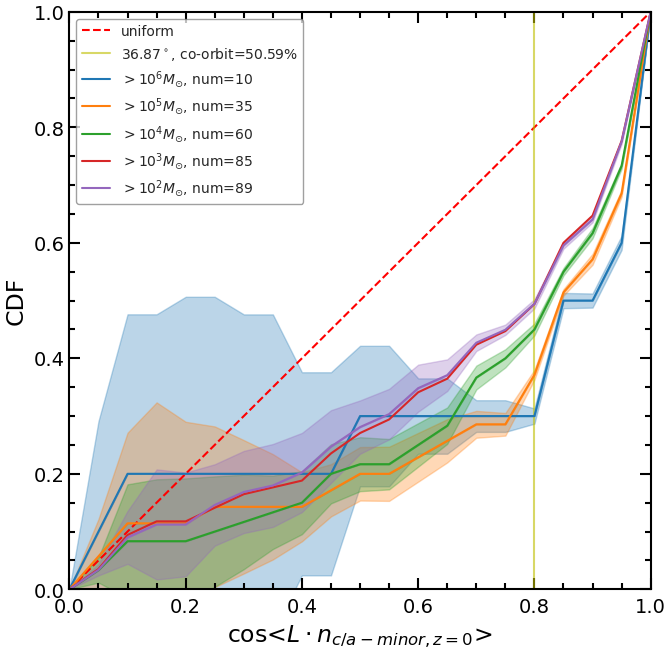

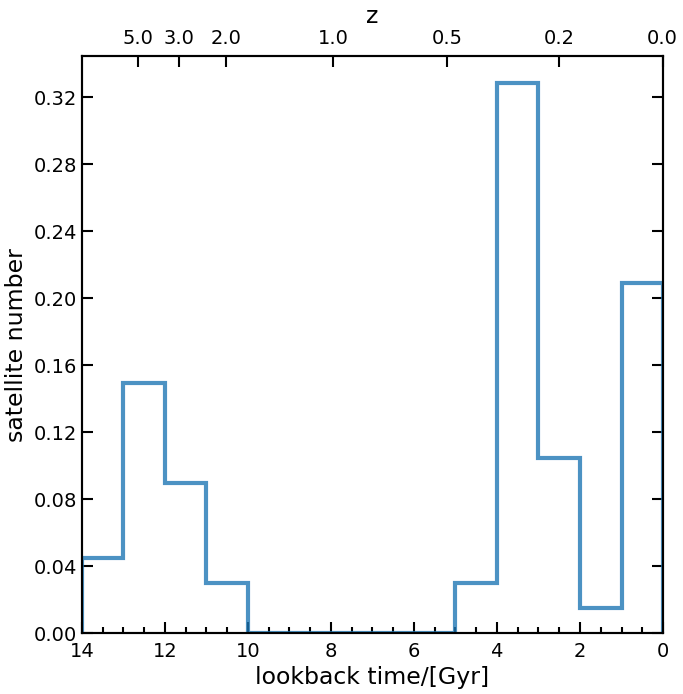

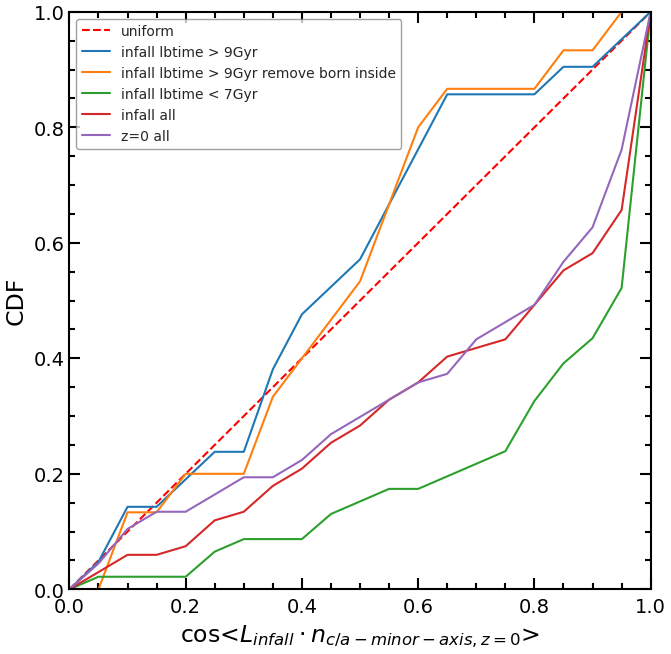

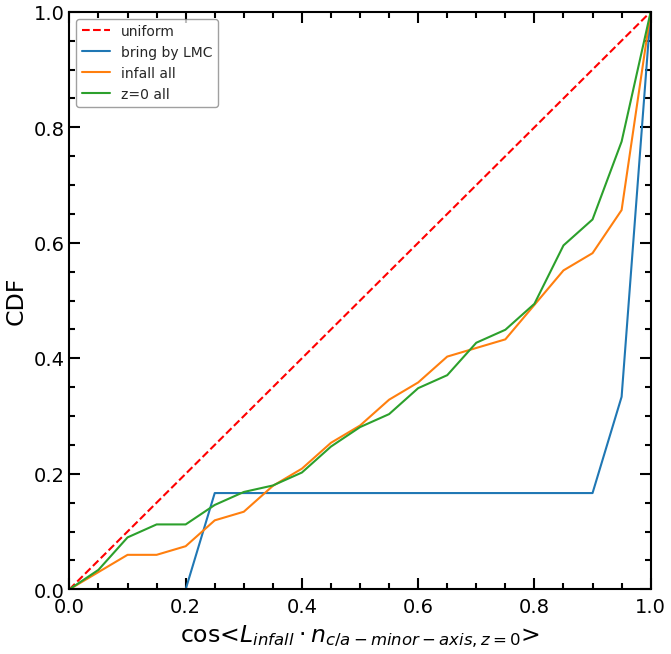

In [26]:
# %matplotlib agg

# angle_l_stack = [np.array([]),np.array([]),np.array([]),np.array([]),np.array([])]

angle_l_stack = [[],[],[],[],[]]
z_infall_stack = []
angle_r200_infall_early_stack = []
angle_r200_early_remove_born_stack = []
angle_r200_infall_late_stack = []
angle_satellite_L_infall_stack = []
angle_bring_by_lmc_L_infall_stack= []
# angle_bring_by_lmc()

for system in systems:
    # read_satellite_orbit_Galform
    satelliteFile = root_satelliteFiles + list_satelliteFiles[system]
    print('------------------------------------------------------------------------------------------------')
    print("Reading system '%i' info from the file '%s' ..." %
          (system, satelliteFile))
    satellite_ID, satellite_mstar, satellite_pos, satellite_vel, is_destructed, is_satellite,\
        t, a, h, z =  read_satellite_orbit_Galform(satelliteFile)
    L = np.cross(satellite_pos, satellite_vel) 
    L = L / np.linalg.norm(L, axis=2)[:, :, np.newaxis]
    satellite_num = len(satellite_pos)
    simulation_name = simulation_names[system]
    central_R200 = np.loadtxt('./data/mw_r200_' + simulation_name)


    # analyse z=0 after destruction
    dm_halo_minor = dm_halo_minor_l[system]
    L_z0 = L[:,0,:]
    # L_z0 = L_z0 / np.linalg.norm(L_z0, axis=1)[:, np.newaxis] # normalization
    sort = np.argsort(satellite_mstar[:,0]) # from faint to massive
    Top11_index = sort[-11:]
    c_a, gal_c_a_minor = cal_c_a_ratio(satellite_pos[Top11_index,0,:])
    # if system == 1:
    #     gal_c_a_minor = np.array([ 0.4216255 ,  0.72633549, -0.54283395])
    alpha, gal_alpha_axis = cal_alpha(L_z0[Top11_index])
    axis = 'c_a_minor'
    # axis = 'dmhalo_minor'
    # axis = 'alpha_axis'
    angle_L_to_axis = abs(np.dot(L_z0, gal_c_a_minor))
    angle_l = np.array([angle_L_to_axis[satellite_mstar[:,0]>1e6],  
                        angle_L_to_axis[satellite_mstar[:,0]>1e5],
                        angle_L_to_axis[satellite_mstar[:,0]>1e4],
                        angle_L_to_axis[satellite_mstar[:,0]>1e3],
                        angle_L_to_axis[satellite_mstar[:,0]>1e2]])
    print("c/a=", c_a, "\n", chr(945)+"8=", alpha)
    print("angle between dm_halo_minor and gal_c_a_minor = ", cal_angle(gal_c_a_minor, dm_halo_minor))
    print("angle between gal_c_a_minor and gal_alpha_axis", cal_angle(gal_c_a_minor, gal_alpha_axis))
    print("angle between gal_alpha_axis and dm_halo_minor= ", cal_angle(gal_alpha_axis, dm_halo_minor))
    draw_L_CDF(angle_l, axis)


    # read hydro data
    
    # simulation_num = system + 1
    # central_R200_z0, hydro_satellite_data, hydro_pos, hydro_vel = read_hydro(simulation_num, simulation_name, maxn=1000)
    # axis_num = 5
    # e_l = np.zeros((axis_num,3))
    # e_l[0] = dm_halo_minor[simulation_num-1]
    # e_l[1] = gal_c_a_minor
    # e_l[2] = gal_alpha_axis

    # c_a, e_l[3]  = cal_c_a_ratio(hydro_pos[:11])
    # hydro_L = np.cross(hydro_pos, hydro_vel)
    # for i in range(len(hydro_L)):
    #     hydro_L[i] = hydro_L[i] / np.linalg.norm(hydro_L[i])
    # angle_hydro_L = abs(np.dot(hydro_L, e_l[3])).tolist()
    # alpha, e_l[4] = cal_alpha(hydro_L[:11])
    # print('hydro: c/a=', c_a, "\n", chr(945)+"8=", alpha)
    # print("angle between = ", cal_angle(e_l[3], e_l[4]))


    # analyse infall time and L infall
    is_within_r200 = np.linalg.norm(satellite_pos[:,0], axis=1)<central_R200[0]
    satellite_mstar_r200 = satellite_mstar[is_within_r200]
    satellite_pos_r200 = satellite_pos[is_within_r200]
    satellite_vel_r200 = satellite_vel[is_within_r200]
    lookbackTime = cosmo.age(0) - t
    satellite_num_r200 = len(satellite_pos_r200)
    dis_l = np.zeros((satellite_num_r200,199))
    infall_index = np.zeros(satellite_num_r200 , dtype=int)
    for i in range(satellite_num_r200):
        for j in range(199):
            dis_l[i][j] = np.linalg.norm(satellite_pos_r200[i][j]) * a[j]
            if (dis_l[i][j]> central_R200[j] and infall_index[i]==0):
                infall_index[i] = j
    z_infall = z[infall_index]
    draw_lbtime_PDF(z_infall)


    infall_lbtime = cosmo.age(0) - t[infall_index]
    z_infall = z[infall_index]
    early_infall_galaxy = infall_lbtime>10
    late_infall_galaxy = infall_lbtime<5
    born_infall_galaxy = z_infall>3.0
    early_infall_galaxy_remove_born_infall = early_infall_galaxy & born_infall_galaxy
    # early_infall_galaxy_remove_born_infall = np.array([x for x in early_infall_galaxy if x not in set_born_infall_galaxy])
    
    
    # satellite_L_r200 = np.cross(satellite_vel_r200, satellite_pos_r200)
    satellite_L_infall = np.zeros((sum(is_within_r200),3))
    for i in range(sum(is_within_r200)):
        satellite_L_infall[i] = L[is_within_r200][i,infall_index[i]]
    angle_L_infall = abs(np.dot(satellite_L_infall, gal_c_a_minor))
    angle_r200_infall_late = angle_L_infall[late_infall_galaxy]
    angle_r200_infall_early = angle_L_infall[early_infall_galaxy]
    angle_r200_early_remove_born = angle_L_infall[early_infall_galaxy_remove_born_infall]



    # xlabel = 'cos<$L_{infall}\cdot n_{dm halo minor,z=0}$>'
    # xlabel = r'cos<$L_{infall}\cdot n_{\alpha8-axis,z=0}$>'
    xlabel = r'cos<$L_{infall}\cdot n_{c/a-minor-axis,z=0}$>'
    draw_cdf(data = [angle_r200_infall_early, 
                    angle_r200_early_remove_born,
                    angle_r200_infall_late, 
                    angle_L_infall, 
                    np.array(angle_l[-1])[is_within_r200]], 
            legends =["infall lbtime > 9Gyr", 
                    "infall lbtime > 9Gyr remove born inside", 
                    "infall lbtime < 7Gyr", 
                    "infall all",
                    "z=0 all"],
            xlabel = xlabel,
            title = 'depedence on infall time', 
            save = False)


    # find the groupnumber and subgroupnumber for each satellite
    # read the data from the Galform file
    if system != 2:
        galformFile = root_galformFiles + list_galformFiles[system]
        gal_subID = readGalformGalsubID(
                galformFile, centralIndeces[system], R_max=400, Mstar_min=1)
        print("\tReading subhalo mass at various redshifts ...")
        subhaloFile = root_subhaloFiles + list_subhaloFiles[system]
        gal_GroupNumber,gal_SubGroupNumber = np.array(readGrpNum(subhaloFile, gal_subID))
        MW_GroupNumber, MW_SubGroupNumber = gal_GroupNumber[0],gal_SubGroupNumber[0]
        gal_GroupNumber,gal_SubGroupNumber = gal_GroupNumber[1:][is_satellite],gal_SubGroupNumber[1:][is_satellite]


        central_GroupNumber = central_GroupNumber_l[system]
        is_central_group= gal_GroupNumber[:,0] == MW_GroupNumber[0]
        print("m>100, groupnumber=1, not destructed satellite num = ", sum(is_satellite))
        satellite_num = sum(is_central_group)
        
        satellite_GroupNumber = gal_GroupNumber[is_central_group]
        satellite_SubGroupNumber = gal_SubGroupNumber[is_central_group]
        # satellite_Mstar = gal_Mstar[1:][is_satellite]
        # lmc_index = satellite_Mstar[:,0].argsort()[-1]
        lmc_index = np.where(satellite_SubGroupNumber[:,0] == 1)[0][0]
        lmc_GroupNumber = satellite_GroupNumber[lmc_index,:]
        lmc_SubGroupNumber = satellite_SubGroupNumber[lmc_index,:]

        bring_by_lmc_L_infall = []
        for i in range(satellite_num):
            for j in range(199):
                # if this central of this satellite isn't MW progenitor
                if satellite_GroupNumber[i,j] != MW_GroupNumber[j]:
                    # then it is the time it infalls, record this snap num
                    # bring_by_lmc_infall_index[i] = j
                    # further if at this time, the central of this satellite is lmc, it is bring by lmc
                    if satellite_GroupNumber[i,j] == lmc_GroupNumber[j]:
                        # bring_by_lmc_infall_index.append(j)
                        # bring_by_lmc[i] = True
                        print(i,j)
                        bring_by_lmc_L_infall.append(L[is_central_group][i,j,:])
                    break

        angle_bring_by_lmc_L_infall = abs(np.dot(bring_by_lmc_L_infall, gal_c_a_minor))

        draw_cdf(data = [ angle_bring_by_lmc_L_infall,
                        angle_L_infall, 
                        np.array(angle_l[-1])], 
                legends =["bring by LMC",  
                        "infall all",
                        "z=0 all"],
                xlabel = xlabel,
                title = 'L bring by LMC')
    if stack:
        for i in range(len(angle_l)):
            angle_l_stack[i] = np.concatenate((angle_l_stack[i], angle_l[i]))
        z_infall_stack.append(z_infall)
        angle_r200_infall_early_stack.append(angle_r200_infall_early)
        angle_r200_early_remove_born_stack.append(angle_r200_early_remove_born)
        angle_r200_infall_late_stack.append(angle_r200_infall_late) 
        angle_satellite_L_infall_stack.append(angle_L_infall)
        angle_bring_by_lmc_L_infall_stack.append(angle_bring_by_lmc_L_infall)

<div class="alert alert-block alert-danger">

It is good to avoid red boxes but can be used to alert users to not delete some important part of code etc.

</div>

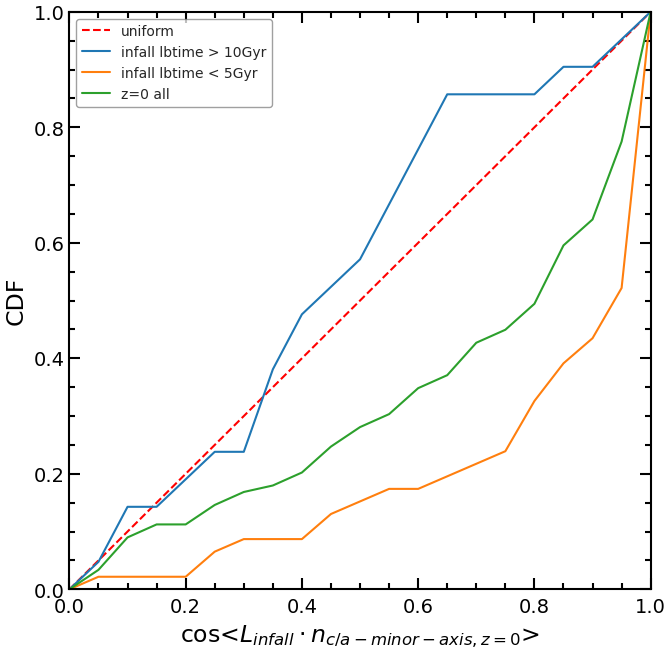

In [28]:
draw_cdf(data = [ angle_r200_infall_early_stack[0], 
                #    angle_r200_early_remove_born_stack[0],
                   angle_r200_infall_late_stack[0], 
                #    angle_satellite_L_infall_stack[0], 
                    np.array(angle_l_stack[-1])] ,
            legends =["infall lbtime > 10Gyr", 
                #     "infall lbtime > 10Gyr remove born inside", 
                    "infall lbtime < 5Gyr", 
                #     "infall all",
                    "z=0 all"],
            xlabel = xlabel,
            title = 'stack L depedence on infall time', 
            save = False)

In [9]:
len(z_infall_stack)

4

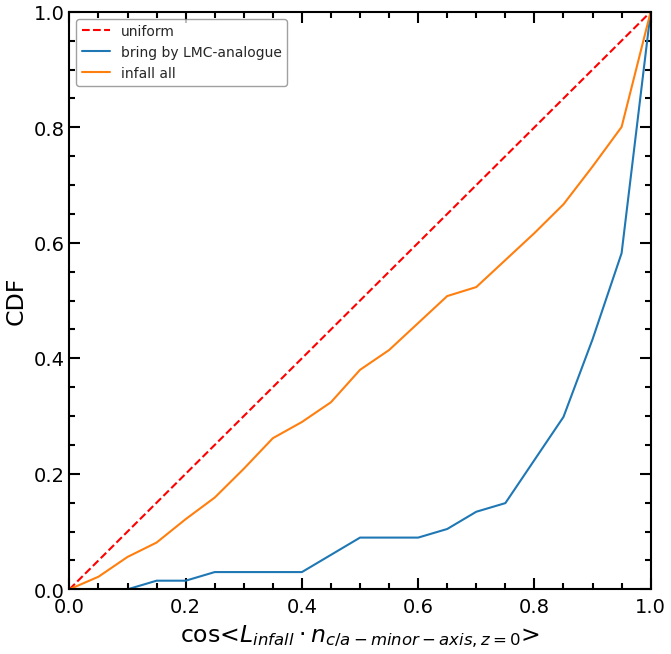

In [17]:
draw_cdf(data = [ np.concatenate(angle_bring_by_lmc_L_infall_stack),
                    np.concatenate(angle_satellite_L_infall_stack), 
                    # np.array(angle_l_stack[-1])
                    ], 
            legends =["bring by LMC-analogue",  
                    "infall all",
                    # "z=0 all"
                    ],
            xlabel = xlabel,
            title = 'stack L bring by LMC-analogue')

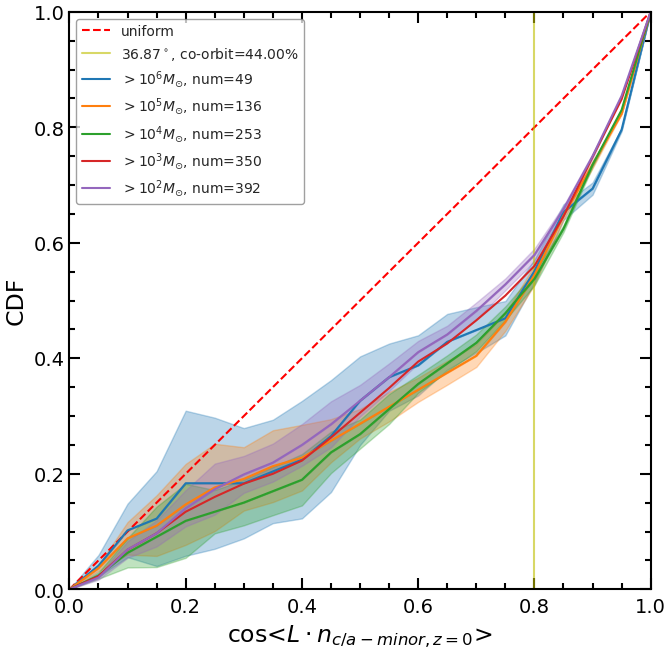

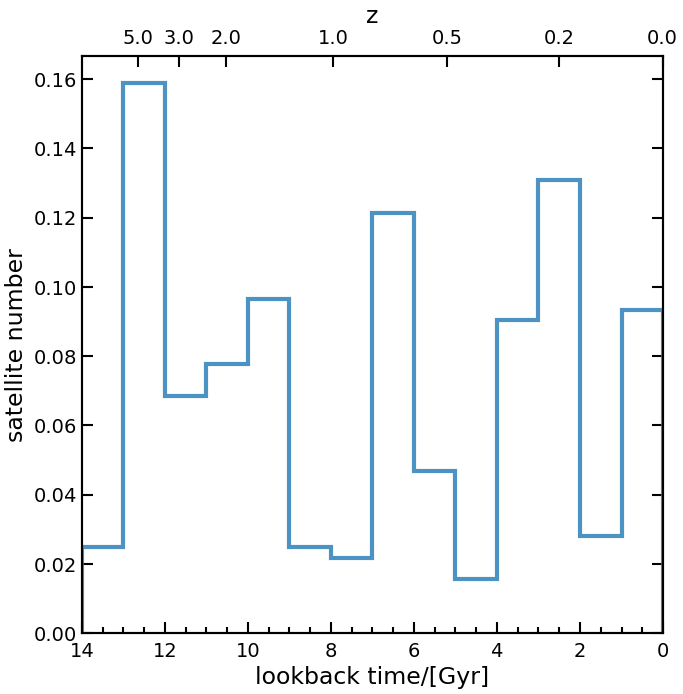

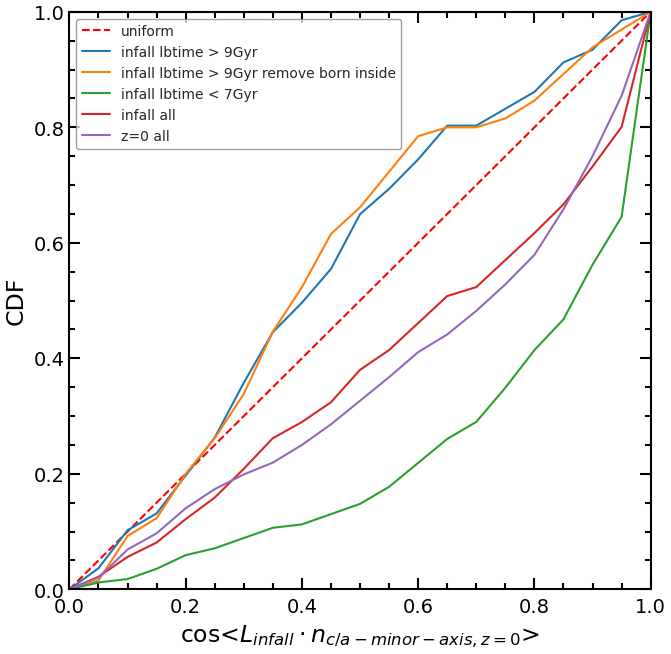

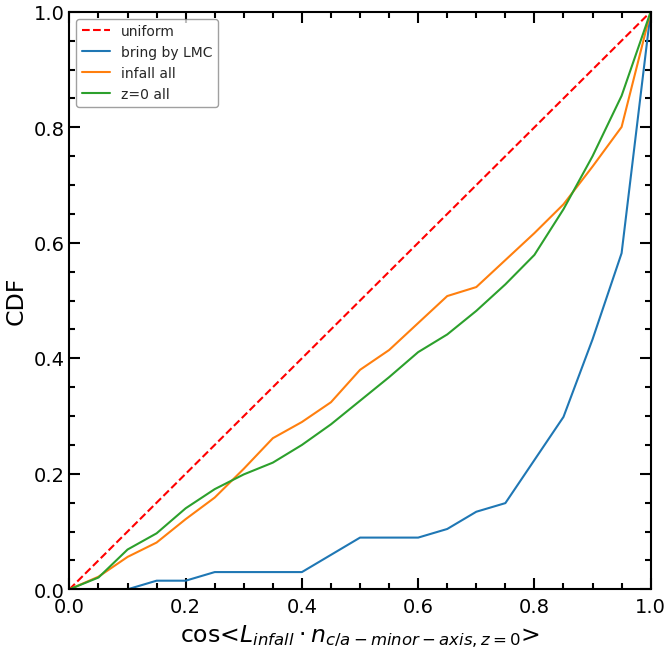

In [36]:
draw_L_CDF(angle_l_stack, save=True, title="L infall time stack")
draw_lbtime_PDF(np.concatenate(z_infall_stack), save=True, title="infall time stack")
draw_cdf(data = [ np.concatenate(angle_r200_infall_early_stack), 
                    np.concatenate(angle_r200_early_remove_born_stack),
                    np.concatenate(angle_r200_infall_late_stack), 
                    np.concatenate(angle_satellite_L_infall_stack), 
                    np.array(angle_l_stack[-1])], 
            legends =["infall lbtime > 9Gyr", 
                    "infall lbtime > 9Gyr remove born inside", 
                    "infall lbtime < 7Gyr", 
                    "infall all",
                    "z=0 all"],
            xlabel = xlabel,
            title = 'stack L depedence on infall time', 
            save = True)

draw_cdf(data = [ np.concatenate(angle_bring_by_lmc_L_infall_stack),
                    np.concatenate(angle_satellite_L_infall_stack), 
                    np.array(angle_l_stack[-1])], 
            legends =["bring by LMC",  
                    "infall all",
                    "z=0 all"],
            xlabel = xlabel,
            title = 'stack L bring by LMC', 
            save = True)

In [93]:
infall_lbtime = np.array([cosmo.lookbackTime(z_) for z_ in z_infall_stack[2]])

(14.0, 0.0)

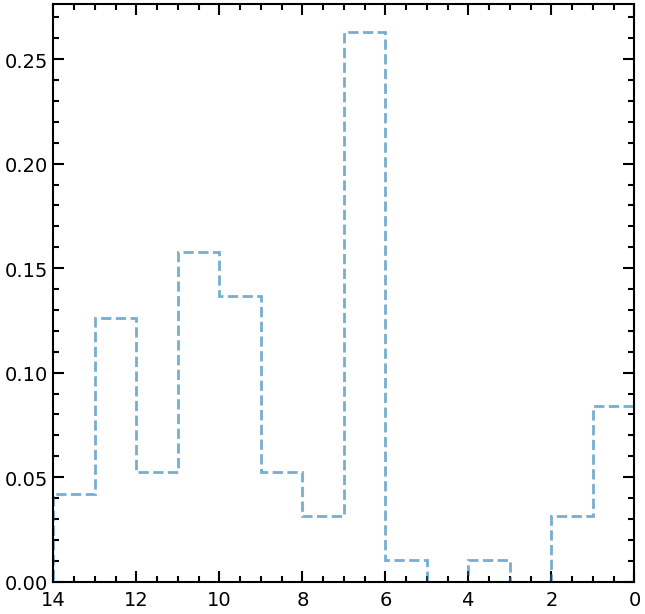

In [95]:
ax1 = plt.gca()
bins = np.linspace(0,14,15)
N, bins, patches = ax1.hist(infall_lbtime, bins,alpha=0.6, histtype='step', linestyle = 'dashed', linewidth=2, density=True,label='M'+str(i+1))
ax1.set_xlim(14,0)

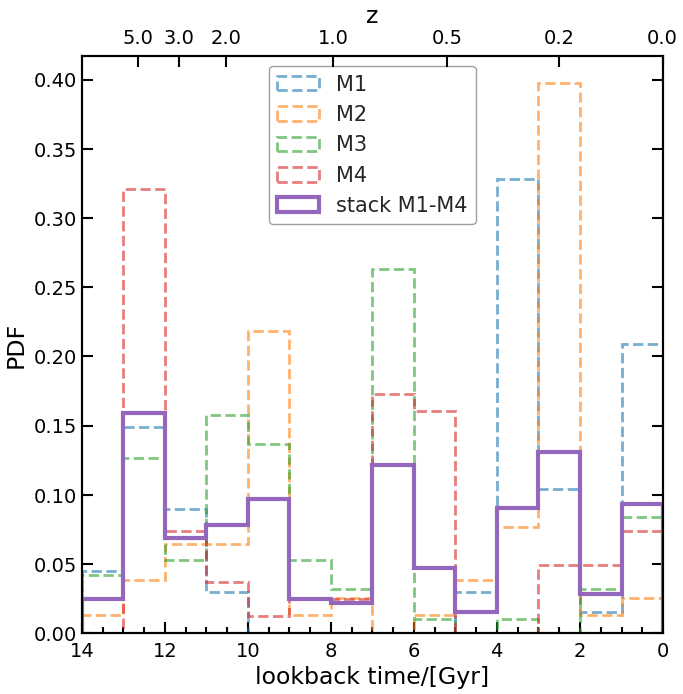

In [65]:
from matplotlib.ticker import MaxNLocator
# plt.title(simulation_name + ' infall time PDF')
plt.figure()
ax1 = plt.gca()
bins = np.linspace(0,14,15)
for i in range(len(z_infall_stack)):
    infall_lbtime = np.array([cosmo.lookbackTime(z_) for z_ in z_infall_stack[i]])
    N, bins, patches = ax1.hist(infall_lbtime, bins,alpha=0.6, histtype='step', linestyle = 'dashed', linewidth=2, density=True,label='M'+str(i+1))

infall_lbtime = np.array([cosmo.lookbackTime(z_) for z_ in np.concatenate(z_infall_stack)])
N, bins, patches = ax1.hist(infall_lbtime, bins,alpha=1, histtype='step', linewidth=3, density=True, label='stack M1-M4')
plt.legend()
# average_pdf = np.histogram(infall_lbtime, bins=30, density=True)[0]
# bin_edges = np.histogram(infall_lbtime, bins=30, density=True)[1]
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# np.histogram(bin_centers, average_pdf, 'r-', label='Average PDF')

ax1.set_xlabel('lookback time/[Gyr]')
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  
ax1.set_xlim(14,0)

def lbtime2z(lbtime):
    t_universe = cosmo.age(0)
    z = cosmo.age(t_universe - lbtime, inverse = True)
    return ["%.1f" % z_ for z_ in z]

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
new_tick_locations = np.array([0.01, cosmo.lookbackTime(0.2), cosmo.lookbackTime(0.5), cosmo.lookbackTime(1), cosmo.lookbackTime(2), cosmo.lookbackTime(3), cosmo.lookbackTime(5)])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(lbtime2z(new_tick_locations))
# ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
# ax2.xtick.minor.visible:=False
# ax.xaxis.set_minor_locator([])
ax2.minorticks_off()
ax2.set_xlabel('z')
ax1.set_ylabel('PDF')
title = 'stack infall time PDF with each dashed'
# if save:
plt.savefig('fig/'+title + '.png', dpi=300)

In [ ]:
z_infall_stack

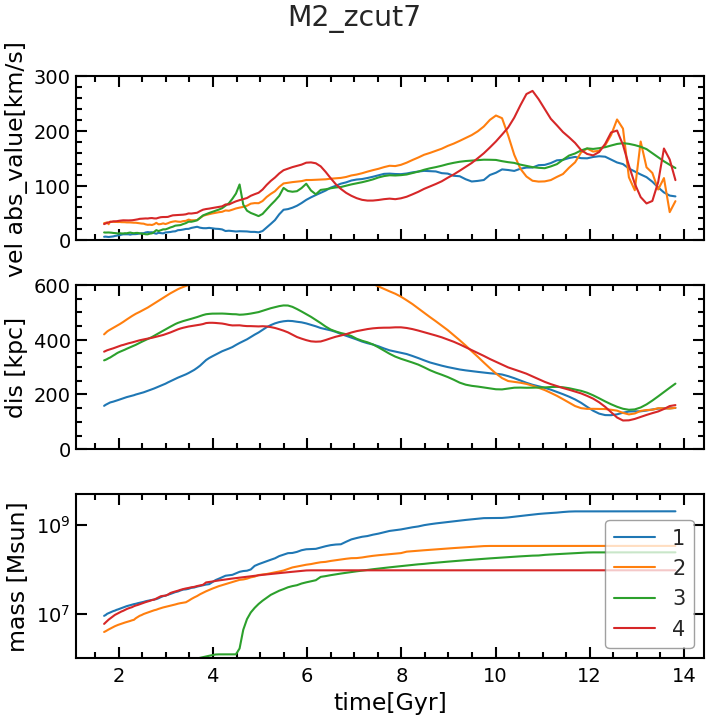

In [382]:
sort = np.argsort(satellite_mstar[:,0])
satellite_dis = np.linalg.norm(satellite_pos, axis=2)
satellite_vel_abs = np.linalg.norm(satellite_vel, axis=2)

fig, (ax1, ax2,ax3) = plt.subplots(3,1,sharex = True)
start_index = 60
for i in range(4):
    ax1.plot(t[:-start_index], satellite_vel_abs[sort[-i-1]][:-start_index], label=i+1)
    ax2.plot(t[:-start_index], satellite_dis[sort[-i-1]][:-start_index], label=i+1)
    ax3.semilogy(t[:-start_index], satellite_mstar[sort[-i-1]][:-start_index], label=i+1)
ax1.set_ylabel('vel abs_value[km/s]')
ax1.set_ylim(0,300)
ax2.set_ylabel('dis [kpc]')
ax2.set_ylim(0,600)
ax3.set_ylabel('mass [Msun]')
ax3.set_ylim(1e6,5e9)
plt.xlabel('time[Gyr]')
plt.suptitle(simulation_name)
plt.tight_layout()
plt.legend()

In [231]:
satellite_mstar_r200

array([[5.86781961e+05, 5.86756092e+05, 5.86723537e+05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.38542782e+04, 2.38542782e+04, 2.38542782e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.18683127e+06, 3.18682795e+06, 3.18682426e+06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.15931486e+03, 1.15931486e+03, 1.15931486e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.01860014e+02, 3.01860014e+02, 3.01860014e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.72662296e+02, 2.72662161e+02, 2.72662026e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [200]:
satellite_dis.shape

(78, 199)

In [81]:
satellite_pos_r200.shape

(78, 199, 3)

In [810]:
simulation_num = 3
simulation_name = 'M' + str(simulation_num) + '_zcut7'
file = "/home/zhaox/Magpie/Destruction/satellite_orbits_Galform/M" + str(simulation_num) + "_MR.hdf5"
with h5py.File(file, 'r' ) as hf:
    # data = hf[inputFile]
    # print ("data.keys = " , data.keys())
    # gid = data['GalaxyID'][:]
    # num = len(gid)
    # print("hf.keys()", hf.keys())
    # print("hf/satellite_galaxies.keys()",hf['satellite_galaxies'].keys())
    # t = hf["header_info/time"][:]
    # a = hf["header_info/scale_factor"][:]
    # h = hf['header_info/h'][()].astype(np.float64)
    # central_Mhalo = hf['central_galaxy/Mhalo'][:]
    
    satellite_mstar = hf['satellite_galaxies/Mstar'][:]
    # satellite_msub = hf['satellite_galaxies/Msub'][:]
    satellite_mhalo = hf['satellite_galaxies/Mhalo'][:]
    satellite_pos = hf['satellite_galaxies/pos'][:]
    # central_pos = hf['satellite_galaxies/pos'][:]
    satellite_vel = hf['satellite_galaxies/vel'][:]
    satellite_R200 = hf['satellite_galaxies/R200'][:]
    satellite_type = hf['satellite_galaxies/type'][:]
    # is_MW_central = hf['satellite_galaxies/is_MW_central'][:]
    # Last snapshot at which the galaxy is a FOF central subhalo. Different from Galform definition of central galaxy.
    # satellite_snap_last_FOF_central = hf['satellite_galaxies/snap_last_FOF_central'][:]
    # Last snapshot at which the galaxy was a central.
    # satellite_snap_last_central = hf["satellite_galaxies/snap_last_central"][:]
    # satellite_type = hf["satellite_galaxies/type"][:]


    destruction = hf["tidal_disruption/destroyed_orbit_interpolation"][:]

    for i in range(len(satellite_type)):
        if satellite_type[i,0] != 2:
            # if destruction[i] == True:
                # print("xxx")
            destruction[i] = False

    print("d<400kpc, m>1, before destruction,satellite num=:", len(satellite_mstar))
    print("d<400kpc, m>1, after destruction,satellite num=:", sum(destruction==False))
    
    distance_z0 = np.linalg.norm(satellite_pos[:,0,:], axis=1)
    print("d<300kpc, m>100, satellite num=", sum((satellite_mstar[:,0]>=100) & (distance_z0<=300)))
    is_satellite = (satellite_mstar[:,0]>=Mstar_min) & (destruction==False) & (distance_z0<=R_max)
    print("d<%dkpc, m>%d after destruction satellite num="%(R_max, Mstar_min), sum(is_satellite))
    r200 = 1.332908272743225098e-01*1000/h
    print("d<r200, m>100, before destruction, satellite num=", sum((satellite_mstar[:,0]>=100) & (distance_z0<=r200)))
    is_satellite = (satellite_mstar[:,0]>=Mstar_min) & (destruction==False) & (distance_z0<=r200)
    print("d<r200, m>100, after destruction satellite num=", sum(is_satellite))

    is_satellite2 = (satellite_mstar[:,0]>=Mstar_min) & (destruction==False) & (gal_GroupNumber[:,0] == central_GroupNumber)
    print("m>100, Gnum=centralGnum, after destruction satellite num=", sum(is_satellite2))

    r50 = r200*(2**2/3)
    print("d<r50, m>100, before destruction, satellite num=", sum((satellite_mstar[:,0]>=100) & (distance_z0<=r50)))
    is_satellite3 = (satellite_mstar[:,0]>=Mstar_min) & (destruction==False) & (distance_z0<=r50)
    print("d<r50, m>100, after destruction satellite num=", sum(is_satellite3))


d<400kpc, m>1, before destruction,satellite num=: 232
d<400kpc, m>1, after destruction,satellite num=: 153
d<300kpc, m>100, satellite num= 181
d<300kpc, m>100 after destruction satellite num= 106
d<r200, m>100, before destruction, satellite num= 156
d<r200, m>100, after destruction satellite num= 83
m>100, Gnum=centralGnum, after destruction satellite num= 100
d<r50, m>100, before destruction, satellite num= 175
d<r50, m>100, after destruction satellite num= 100


In [816]:
sort = np.argsort(satellite_mstar[:,0])

In [819]:
distance_z0[6]

365.8548020649572

In [817]:
sort

array([171,  89,  56, 179, 139,  76,  51, 220, 137, 219,   5,  96, 216,
        46, 147, 180, 122, 191,  28, 215,  30, 145,  68, 181,  39, 154,
       178,  71,  86, 174,  83, 198,   0, 223, 144, 128,  55, 206, 196,
       203,  93, 177, 208,  62,   8,  69,  50, 166, 197, 212,  29,  87,
       124,  73, 187,  44, 157, 158, 106, 221, 229, 207, 131,  43, 211,
       108, 153, 162,  17, 190, 155, 193, 200, 217, 230, 195, 123, 201,
       115,  65, 192, 136, 140,  84, 113, 199, 182, 112, 118, 210, 189,
       186, 194,  79,  97, 214,  15, 188, 127,  82, 148, 228, 125, 164,
       120, 129, 163,  33,  94, 175,  37, 205, 209, 173, 185,  16, 176,
       168, 133, 165, 102, 183, 169, 202, 130, 156, 104, 100, 152,  85,
        45,  34, 161, 138,  70, 159,  67, 142,  92,  49, 132, 170,  88,
        52, 121, 111, 135,  90, 151, 213, 146, 218, 150, 172,  35, 225,
       107, 116,  81,  98,  36,  63, 184,  21, 204, 160, 110, 222,  75,
       167, 231, 126,  40,  95,  78, 134,  24,  77,  66,  48,  4

In [809]:
gal_GroupNumber.shape

(232, 199)

In [277]:
r200*(2**2/3)

262.2415633157398

In [ ]:
np.min(gal_Mstar[])

In [242]:
gal_Mstar

(142, 199)

In [262]:
satellite_type.shape

(141, 199)

In [61]:
gal_pos_relative = (gal_pos[:,:,:] - gal_pos[0,:,:]) *1000/ h
satellite_dis = np.linalg.norm(gal_pos_relative, axis=2) * a

In [59]:
gal_pos_relative.shape

(158, 199, 3)

In [15]:
sort = np.argsort(gal_Mstar[:,0])

In [18]:
sort

array([  2, 116,  98, 109, 139,  47, 113,  13,  58,  86,  85,  87, 149,
       145,   8, 132,  28,  74,  83, 104, 117,  52,  88, 121, 148,  43,
        69, 143, 140, 146,  84, 131, 133,  93, 124,  68, 141,  82, 115,
       106,  90,  46, 114, 125,  81,  78,  23,  96,  92, 129, 155, 118,
       142, 122, 134,  36, 135, 144, 126, 147, 123, 137, 130,  79, 108,
       111, 105,  77,  56, 120,  20, 119,  95, 153, 100,  65,   3,  53,
        26, 103,  62,  97, 110, 128,  59,  91,  17, 136, 127,  54,  64,
        99,  67,  76, 107, 138,  75, 102,  57,  70,  25,  18,   9,  73,
       152,  15,  89, 156,  22,  50,  21,  42,  61,  45,  71,  12,  66,
        11, 112,  80,  27, 101,  49,  24,  60,  14,  94,  55, 157,  29,
        63,  39,   1,  38, 154,  34,  33,  72,  41, 151,  51,   4,  37,
       150,  32,  31,  16,   7,  35,  48,  44,  40,  19,  30,   5,  10,
         6,   0])

In [40]:
gal_pos_relative.shape


(158, 199, 3)

In [46]:
sort[-2]

6

In [63]:
LMC_pos = gal_pos_relative[sort[-2]]

In [48]:
LMC_pos.shape

(199, 3)

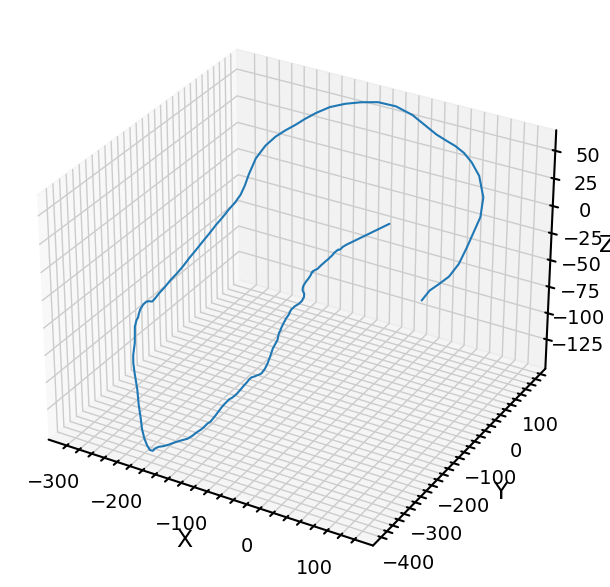

In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 提取x、y和z坐标值
x = LMC_pos[:,0] * a
y = LMC_pos[:,1] * a
z = LMC_pos[:,2] * a

# 绘制轨迹
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x[:], y[:], z[:])

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示图形
plt.show()


In [77]:
t[20]

11.30283

In [205]:
satellite_vel_abs.shape

(78, 199)

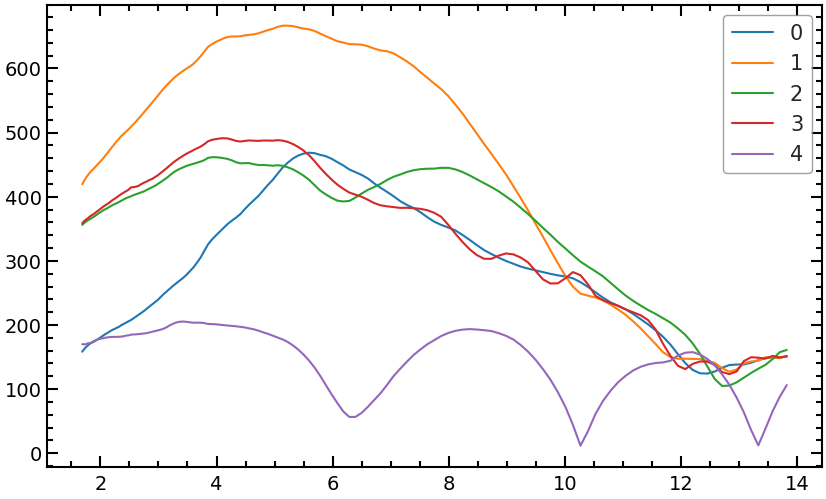

In [209]:
plt.figure(figsize=(10,6))
start_index = 60
for i in range(5):
    plt.plot(t[:-start_index], satellite_dis[sort[-i-1]][:-start_index], label=i)
plt.legend()

In [22]:
gal_vel.shape

(158, 199, 3)

In [25]:
gal_vel_relative = gal_vel - gal_vel[0]

6
10
5
30


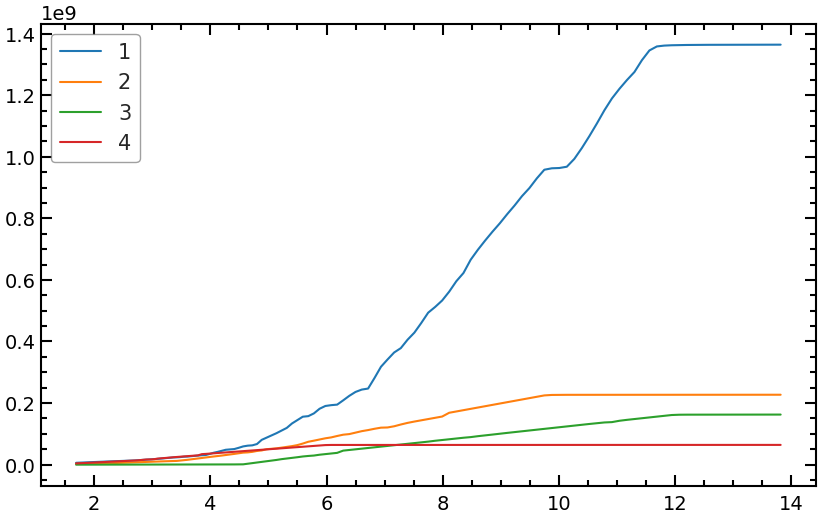

In [24]:
start_index = 60
plt.figure(figsize=(10,6))
for i in range(1,5,1):
    print(sort[-i-1])
    # plt.semilogy(t[:-start_index], gal_Mstar[sort[-i-1]][:-start_index], label=i)
    plt.plot(t[:-start_index], gal_Mstar[sort[-i-1]][:-start_index], label=i)
plt.legend()

In [204]:
gal_vel[123].shape

(199, 3)

In [34]:
np.linalg.norm(gal_vel_relative[satellite_index,:-start_index, :], axis=1).shape

(139,)

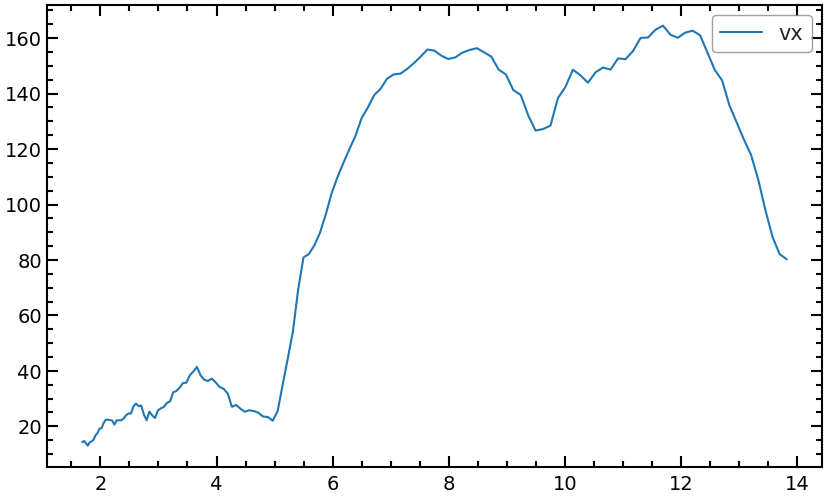

In [33]:
start_index = 60
plt.figure(figsize=(10,6))

    # print(sort[-i-1])
    # plt.semilogy(t[:-start_index], gal_Mstar[sort[-i-1]][:-start_index], label=i)
satellite_index = sort[-2]
plt.plot(t[:-start_index], np.linalg.norm(gal_vel_relative[satellite_index,:-start_index, :], axis=1), label='vx')
plt.legend()

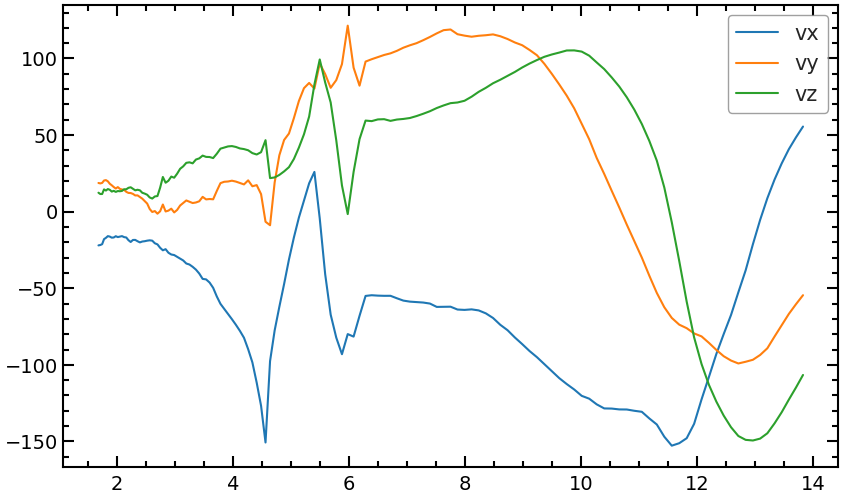

In [79]:
start_index = 60
plt.figure(figsize=(10,6))

    # print(sort[-i-1])
    # plt.semilogy(t[:-start_index], gal_Mstar[sort[-i-1]][:-start_index], label=i)
satellite_index = sort[-4]
plt.plot(t[:-start_index], gal_vel_relative[satellite_index,:-start_index, 0], label='vx')
plt.plot(t[:-start_index], gal_vel_relative[satellite_index,:-start_index, 1], label='vy')
plt.plot(t[:-start_index], gal_vel_relative[satellite_index,:-start_index, 2], label='vz')
plt.legend()

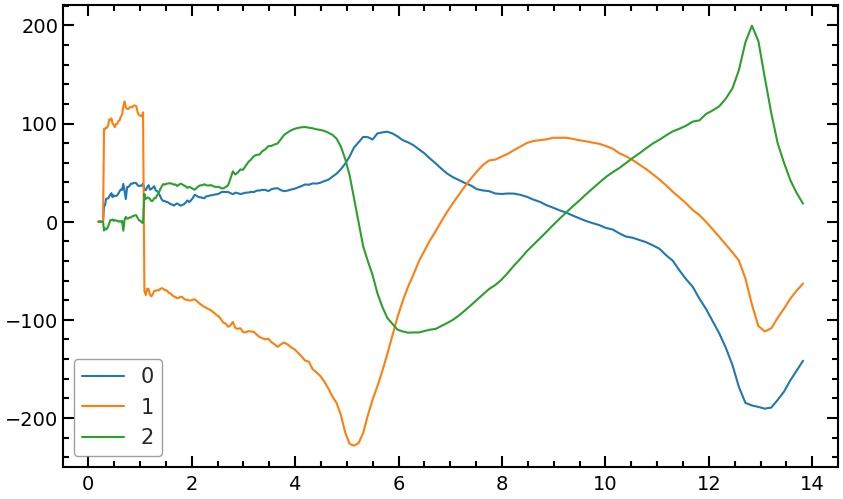

In [209]:
start_index = 60
plt.figure(figsize=(10,6))
for i in range(3):
    # print(sort[-i-1])
    # plt.semilogy(t[:-start_index], gal_Mstar[sort[-i-1]][:-start_index], label=i)
    # plt.plot(t[:-start_index], gal_vel[123,:-start_index, i], label=i)
    plt.plot(t, gal_vel[4,:, i], label=i)
plt.legend()

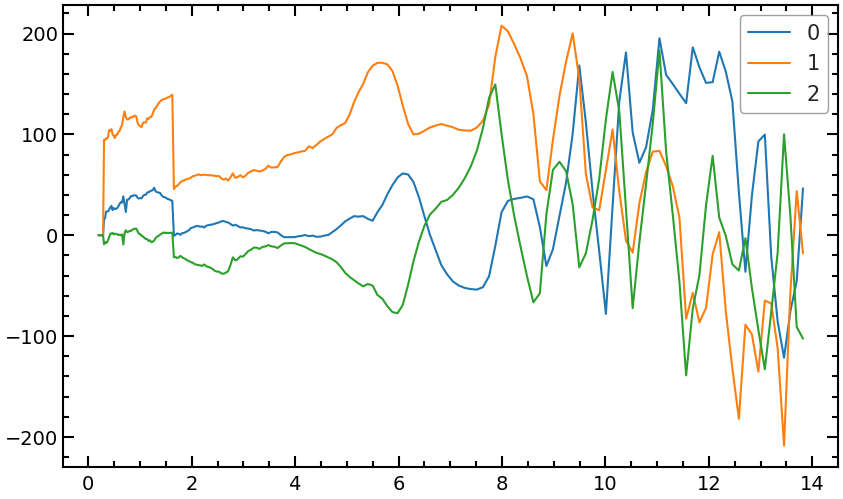

In [210]:
start_index = 60
plt.figure(figsize=(10,6))
for i in range(3):
    # print(sort[-i-1])
    # plt.semilogy(t[:-start_index], gal_Mstar[sort[-i-1]][:-start_index], label=i)
    # plt.plot(t[:-start_index], gal_vel[123,:-start_index, i], label=i)
    plt.plot(t, gal_vel[35,:, i], label=i)
plt.legend()

In [211]:
def print_10_line(data):
    for i in range(1, len(data)+1):
        print(data[i-1],end='\t')
        if i % 10 ==0:
            print()

In [212]:
t[27]

10.397207

In [213]:
gal_Mstar.shape

(158, 199)

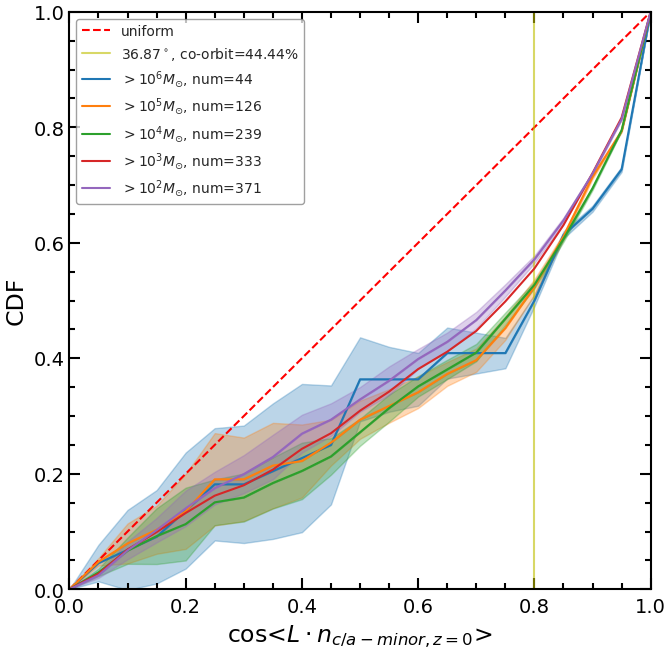

In [ ]:
draw_L_CDF(angle_l_stack, save=True, title='zcut7_angle_l_stack')

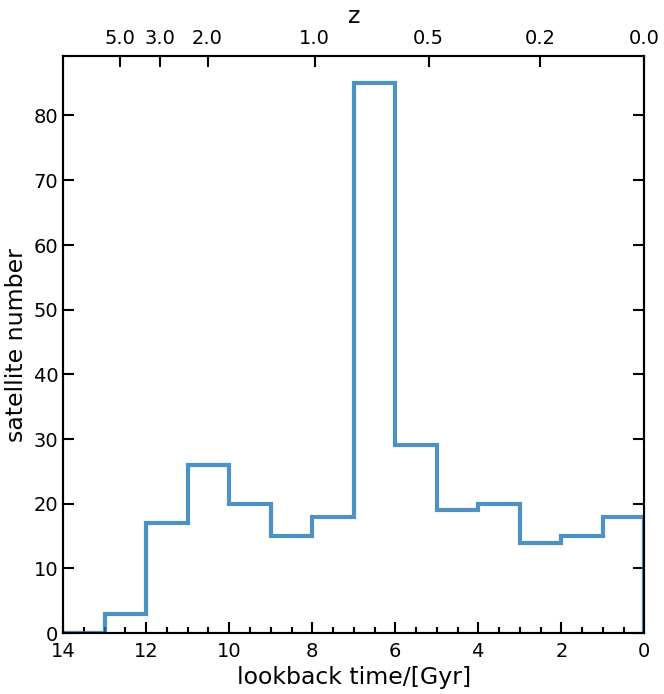

In [ ]:
draw_lbtime_PDF(np.concatenate(infall_index_stack), save=True, title="zcut7_infall_time_stack")

In [ ]:
lmc_index = gal_Mstar[:,0].argsort()[-2]
lmc_group_number = gal_GroupNumber[lmc_index,:]
lmc_subGroup_number = gal_SubGroupNumber[lmc_index,:]

In [ ]:
infall_index_stack

[array([  2,  19,  22,   7,  19,  23,   5,   1,  22,  16,  68,  22,   1,
          6,  26,  14,  31,  23,   6,  18,   9,  70,  98, 104,  23,   1,
        105, 109, 106, 111,  29, 118,  19,   2,  22, 103, 112,  20,   1,
          2,  21,  23,  23,  70,  22,   1,  22, 112,  22,   4,   1, 128,
         22,  21,   2, 104,  22, 121,  96,  22,  97,  22,  22,  23]),
 array([ 11,  15,  15,  19,  20,   2,   5,  22,  34,  21,  34,  14,  23,
         18,  18,  22,  17,  22,  19,  17,  49,  36,  83,  29,  18,  22,
         40,  19,  15,  53,  19,  37,  71,  18,  75,  20,  55,  18,  19,
         79,  43,  74,  13,  78,  86, 113,  10,  80,  99,  20,  12,  82,
         74,  18,  74,  79,  49,  83,  19,  18,  16, 138,  18,  20,  74,
         74,  19,  30,  16,  19,  18,  19,  20,  74]),
 array([  9,   2,  42,  10,  10,   5,  44,  35,  18,  21,  49,  33,  32,
          6,  44,  68,  13,  65,  44,  42,  40,  77,  14,  51,  79,   3,
          2,  83,  89,  72,  87,  53,  43,  21,  82,  43,  43,  20,  44,

In [ ]:
def draw_cdf(data,legends, title, xlabel, save=False, title=None):
    hist_bins = np.arange(0,1.05,0.05)
    index_l = legends

    fig = plt.figure()
    ax = fig.add_subplot()
    # ax.step((xedge[1:]+xedge[:-1])/2.,(h_phe)/np.sum(h_phe),'r-',where='mid')
    # ax.set_xlabel(r'$\Delta RV_{max}$ (km s$^{-1}$)',fontsize=12)
    ax.plot(np.arange(0,1.01,0.01),np.arange(0,1.01,0.01), color = 'red', linestyle = '--', label = 'uniform')

    for i in range(len(data)):
        # index = index_l[i]
        h_1,xedge = np.histogram(data[i],hist_bins)
        index = index_l[i]
        # print(y_fit)
        cdf = np.concatenate(([0],np.cumsum(h_1)/np.sum(h_1)))
        e1, = ax.plot(xedge,cdf, label = f'{index}')
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel('CDF')
    # ax.set_title(title)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    plt.legend(fontsize = 10)
    if save == True:
        plt.savefig('fig/' + title +'.png', dpi=300)

In [ ]:
# central_R200 = np.loadtxt('data/central_r200_'+ simulation_name)

In [ ]:
infall_index

array([ 11,  15,  15,  19,  20,   2,   5,  22,  34,  21,  34,  14,  23,
        18,  18,  22,  17,  22,  19,  17,  49,  36,  83,  29,  18,  22,
        40,  19,  15,  53,  19,  37,  69,  18,  69,  20,  55,  18,  19,
        79,  43,  74,  13,  69,  86, 116,  10,  80,  99,  20,  12,  82,
        74,  18,  74,  69,  49,  83,  19,  18,  16, 138,  18,  20,  74,
        74,  19,  30,  16,  19,  18,  19,  20,  74])

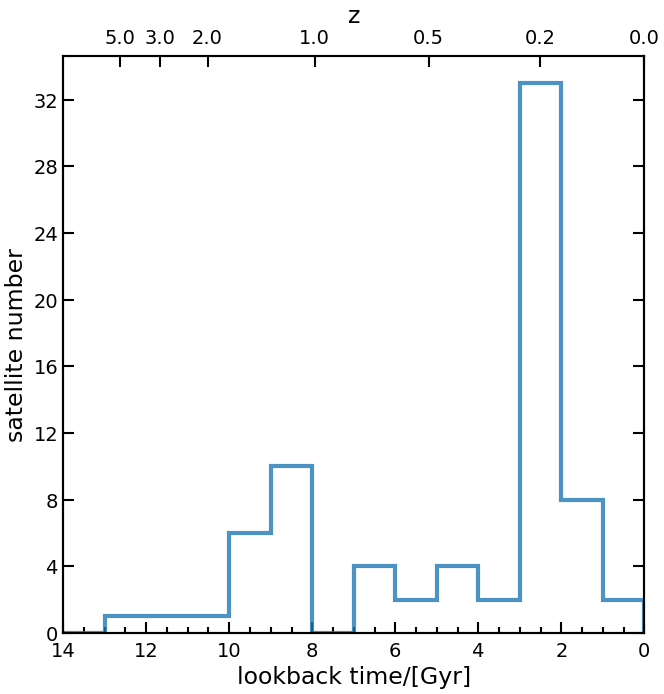

In [ ]:
z = 1/a - 1
z_infall = z[infall_index]
infall_lbtime = np.array([cosmo.lookbackTime(z_) for z_ in z_infall])

from matplotlib.ticker import MaxNLocator
# plt.title(simulation_name + ' infall time PDF')
ax1 = plt.subplot()
bins = np.linspace(0,14,15)
N, bins, patches = ax1.hist(infall_lbtime, bins,alpha=0.8, histtype='step', linewidth=3)
ax1.set_xlabel('lookback time/[Gyr]')
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax1.arrow(lbtime[0],2, 0, -1, width = 0.1, color = 'red')
# ax1.text(lbtime[0]+1,2.5, "lmc infall", fontsize=13)
# ax1.arrow(lbtime[1],2, 0, -1, width = 0.1, color = 'red')
# ax1.text(lbtime[1]+1,2.5, "smc infall", fontsize=13)
# ax1.invert_xaxis()
sort = np.argsort(satellite_mstar[is_within_r200,0])

# ax1.arrow(infall_lbtime[sort[-1]],2, 0, -1, width = 0.1, color = 'orange')
# ax1.text(infall_lbtime[sort[-1]]+1,2.5, "lmc infall", fontsize=13)
# ax1.arrow(infall_lbtime[sort[-2]],2, 0, -1, width = 0.1, color = 'orange')
# ax1.text(infall_lbtime[sort[-2]]+1,2.5, "smc infall", fontsize=13)

ax1.set_xlim(14,0)

# for i in range(1,5):
#     patches[-i].set_facecolor('c')

def lbtime2z(lbtime):
    t_universe = cosmo.age(0)
    z = cosmo.age(t_universe - lbtime, inverse = True)
    return ["%.1f" % z_ for z_ in z]

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
new_tick_locations = np.array([0.01, cosmo.lookbackTime(0.2), cosmo.lookbackTime(0.5), cosmo.lookbackTime(1), cosmo.lookbackTime(2), cosmo.lookbackTime(3), cosmo.lookbackTime(5)])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(lbtime2z(new_tick_locations))
# ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
# ax2.xtick.minor.visible:=False
# ax.xaxis.set_minor_locator([])
ax2.minorticks_off()
ax2.set_xlabel('z')
ax1.set_ylabel('satellite number')
plt.savefig('fig/'+simulation_name + ' infall time PDF.png', dpi=300)

In [ ]:
early_infall_galaxy = np.where(infall_lbtime>8)[0]
late_infall_galaxy = np.where(infall_lbtime<6)[0]
born_infall_galaxy = np.where(z_infall>3.0)[0]
set_born_infall_galaxy = set(born_infall_galaxy)
early_infall_galaxy_remove_born_infall = np.array([x for x in early_infall_galaxy if x not in set_born_infall_galaxy])
print(early_infall_galaxy_remove_born_infall, '\n', late_infall_galaxy)

[22 32 34 39 41 43 44 45 47 48 51 52 54 55 57 64 65 73] 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 23 24 25
 26 27 28 30 31 33 35 37 38 40 42 46 49 50 53 58 59 60 62 63 66 67 68 69
 70 71 72]


In [ ]:
satellite_L_infall = np.zeros((satellite_num_r200,3))
satellite_L_r200 = np.cross(satellite_vel_r200, satellite_pos_r200)
for i in range(len(satellite_L_r200)):
    # satellite_L_r200[i] = satellite_L_r200[i]/ np.linalg.norm(satellite_L_r200[i])
    satellite_L_infall[i] = satellite_L_r200[i][infall_index[i]]

In [ ]:
satellite_L_r200.shape

(74, 199, 3)

In [ ]:
satellite_vel_r200.shape

(74, 199, 3)

In [ ]:
# e3_2 = dm_halo_minor[simulation_num-1]
e3_2 = gal_c_a_minor
# e3_2 = gal_alpha_axis
satellite_L_r200_infall_late = satellite_L_infall[late_infall_galaxy]
satellite_L_r200_infall_late = satellite_L_r200_infall_late/np.linalg.norm(satellite_L_r200_infall_late, axis=1, keepdims=True)
angle_r200_infall_late = abs(np.dot(satellite_L_r200_infall_late, e3_2))

satellite_L_r200_infall_early = satellite_L_infall[early_infall_galaxy]
satellite_L_r200_infall_early = satellite_L_r200_infall_early/np.linalg.norm(satellite_L_r200_infall_early, axis=1, keepdims=True)
angle_r200_infall_early = abs(np.dot(satellite_L_r200_infall_early, e3_2))

satellite_L_r200_early_remove_born = satellite_L_infall[early_infall_galaxy_remove_born_infall]
satellite_L_r200_early_remove_born = satellite_L_r200_early_remove_born/ np.linalg.norm(satellite_L_r200_early_remove_born, axis=1, keepdims=True)
angle_r200_early_remove_born = abs(np.dot(satellite_L_r200_early_remove_born, e3_2))

satellite_L_infall = satellite_L_infall/ np.linalg.norm(satellite_L_infall, axis=1, keepdims=True)
angle_satellite_L_infall = abs(np.dot(satellite_L_infall, e3_2))

In [ ]:
angle_r200_infall_early.shape

(19,)

In [ ]:
angle_r200_early_remove_born.shape

(18,)

In [ ]:
is_within_r200.shape

(98,)

In [ ]:
len(angle_l[-2])

98

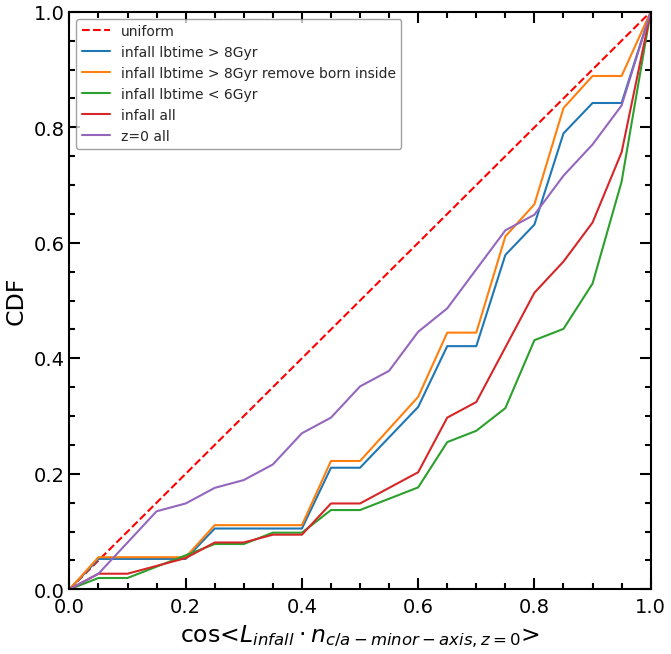

In [ ]:
# xlabel = 'cos<$L_{infall}\cdot n_{dm halo minor,z=0}$>'
# xlabel = r'cos<$L_{infall}\cdot n_{\alpha8-axis,z=0}$>'
xlabel = r'cos<$L_{infall}\cdot n_{c/a-minor-axis,z=0}$>'
draw_cdf(data = [angle_r200_infall_early, 
                 angle_r200_early_remove_born,angle_r200_infall_late, 
                 angle_satellite_L_infall, 
                 np.array(angle_l[-2])[is_within_r200]], 
         legends =["infall lbtime > 8Gyr", 
                   "infall lbtime > 8Gyr remove born inside", 
                   "infall lbtime < 6Gyr", 
                   "infall all",
                   "z=0 all"],
         xlabel = xlabel,
         title = 'depedence on infall time', 
         save = True)

In [ ]:
satellite_R200.shape

(98,)

In [ ]:
sort = np.argsort(satellite_mstar[is_within_r200][:,0])
bring_by_lmc = np.full(sum(is_within_r200),False)
lmc_index = sort[-1]
lmc_infall_index = infall_index[lmc_index]
# lmc_r200 = 227.2 * (satellite_mhalo[is_within_r200][lmc_index, lmc_infall_index]/1.252e12)**0.3333
lmc_r200 = satellite_R200[is_within_r200][lmc_index]
print("lmc_r200=", lmc_r200)
for i in range(len(satellite_pos_r200)):
    distance_to_lmc = np.linalg.norm(satellite_pos_r200[i][lmc_infall_index] - satellite_pos_r200[lmc_index][lmc_infall_index])
    # print(distance_to_lmc)
    if  distance_to_lmc < lmc_r200:
        bring_by_lmc[i] = True
print("num bring by lmc=", sum(bring_by_lmc))

lmc_r200= 157.36134338378906
num bring by lmc= 35


In [ ]:
sort = np.argsort(satellite_mstar[is_within_r200][:,0])
bring_by_smc = np.full(sum(is_within_r200),False)
smc_index = sort[-2]
smc_infall_index = infall_index[smc_index]
# smc_r200 = 227.2 * (satellite_mhalo[is_within_r200][smc_index, smc_infall_index]/1.252e12)**0.3333
smc_r200 = satellite_R200[is_within_r200][smc_index]
print("smc_r200=", smc_r200)
for i in range(len(satellite_pos_r200)):
    distance_to_smc = np.linalg.norm(satellite_pos_r200[i][smc_infall_index] - satellite_pos_r200[smc_index][smc_infall_index])
    # print(distance_to_smc)
    if  distance_to_smc < smc_r200:
        bring_by_smc[i] = True
print("num bring by smc=",sum(bring_by_smc))

smc_r200= 126.66051483154297
num bring by smc= 32


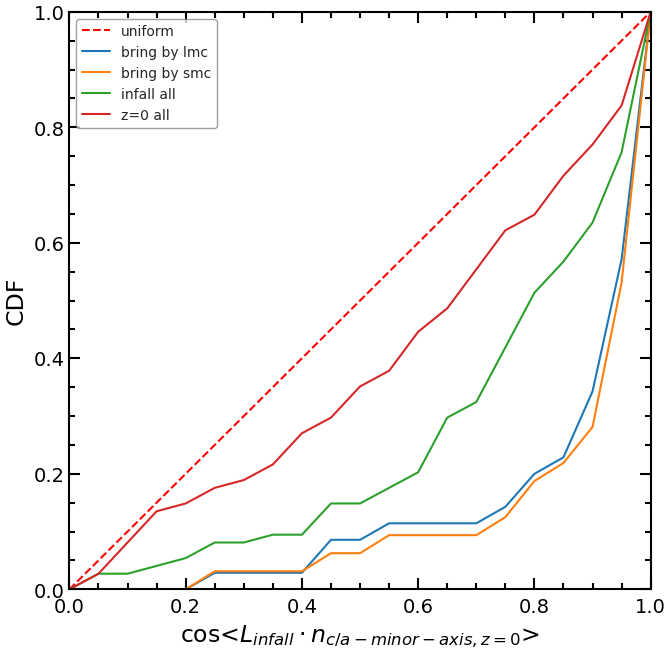

In [ ]:
L_bring_by_lmc_infall = satellite_L_infall[bring_by_lmc]
angle_bring_by_lmc_infall = abs(np.dot(L_bring_by_lmc_infall, e3_2))
L_bring_by_smc_infall = satellite_L_infall[bring_by_smc]
angle_bring_by_smc_infall = abs(np.dot(L_bring_by_smc_infall, e3_2))


draw_cdf([angle_bring_by_lmc_infall, 
          angle_bring_by_smc_infall, 
          angle_satellite_L_infall, 
          np.array(angle_l[-2])[is_within_r200]], 
        ["bring by lmc", "bring by smc", "infall all","z=0 all"],
        title = 'LMC & SMC influence',
        # xlabel = r'cos<$L_{infall}\cdot n_{\alpha8-axis,z=0}$>',
        xlabel = r'cos<$L_{infall}\cdot n_{c/a-minor-axis,z=0}$>',
        save=True)

In [ ]:
import pandas as pd

data = {'simulation_num': np.full(len(infall_lbtime), simulation_num),
        'infall_lbtime':infall_lbtime,
        'angle_satellite_L_infall':angle_satellite_L_infall,
        'z=0 all':np.array(angle_l[-2])[is_within_r200],
        'bring_by_lmc':bring_by_lmc,
        'bring_by_smc':bring_by_smc}

df = pd.DataFrame(data)

In [ ]:
df

,simulation_num,infall_lbtime,angle_satellite_L_infall,z=0 all,bring_by_lmc,bring_by_smc
0,2,1.366229,0.151500,0.117154,False,False
1,2,1.875217,0.685251,0.463488,False,False
2,2,1.875217,0.613885,0.114794,False,False
3,2,2.388623,0.995750,0.962220,True,True
4,2,2.517505,0.915221,0.632747,True,True
...,...,...,...,...,...,...
69,2,2.388623,0.969954,0.944699,True,True
70,2,2.259931,0.991261,0.921015,True,True
71,2,2.388623,0.999217,0.845635,True,True
72,2,2.517505,0.829000,0.242394,True,True


In [ ]:
df_saved = pd.read_csv('satellite_infall_data_new.csv')
df_ = df_saved.append(df)
df_.to_csv('satellite_infall_data_new.csv',index=False)

/tmp/ipykernel_141721/3391613606.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ = df_saved.append(df)
